<a href="https://colab.research.google.com/github/DarynaSherenhova/ecommerce-sales-analytics-sql-python-tableau/blob/main/Online_store_sales_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install google-cloud-bigquery

In [ ]:
from typing import no_type_check
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from scipy.stats import pearsonr
import itertools
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_ztest

auth.authenticate_user()

project_id = 'data-analytics-mate'
client = bigquery.Client(project=project_id)

In [ ]:
query = """
SELECT
  s.date as date,
  s.ga_session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.name as traffic_source_info,
  sp.channel,
  acc.id AS account_id,
  acc.is_unsubscribed,
  acc.is_verified,
  p.category,
  p.name,
  p.price,
  p.short_description
from `DA.session` s
left join `DA.account_session` acs
on acs.ga_session_id = s.ga_session_id

left join `DA.account` acc
on acc.id = acs.account_id

join `DA.session_params` sp
on s.ga_session_id = sp.ga_session_id

left join `DA.order` o
on sp.ga_session_id = o.ga_session_id

left join `DA.product` p
on o.item_id = p.item_id

  """

df = client.query(query).to_dataframe()
df.head()

,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_source_info,channel,account_id,is_unsubscribed,is_verified,category,name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,(organic),Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(direct),Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(direct),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(direct),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce') # Перетворення типу даних в колонці date на datetime

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 349545 non-null  datetime64[ns]
 1   ga_session_id        349545 non-null  Int64         
 2   continent            349545 non-null  object        
 3   country              349545 non-null  object        
 4   device               349545 non-null  object        
 5   browser              349545 non-null  object        
 6   mobile_model_name    349545 non-null  object        
 7   operating_system     349545 non-null  object        
 8   language             235279 non-null  object        
 9   traffic_source_info  349545 non-null  object        
 10  channel              349545 non-null  object        
 11  account_id           27945 non-null   Int64         
 12  is_unsubscribed      27945 non-null   Int64         
 13  is_verified   

In [ ]:
df['ga_session_id'].nunique() # Знаходимо кількість унікальних сесій

349545

In [ ]:
start_date = df['date'].min()
end_date = df['date'].max()
print("Період: від", start_date.date(), "до", end_date.date()) # Знаходимо період часу даних, який розглядається в датасеті

Період: від 2020-11-01 до 2021-01-31


In [ ]:
df.isnull().sum() # Знахомо кількість пропущених значень по кожному стовбцю

,0
date,0
ga_session_id,0
continent,0
country,0
device,0
browser,0
mobile_model_name,0
operating_system,0
language,114266
traffic_source_info,0


In [ ]:
df.isnull().mean() * 100 # Знаходимо відсоток пропущених значень по кожному стовбцю

,0
date,0.000000
ga_session_id,0.000000
continent,0.000000
country,0.000000
device,0.000000
browser,0.000000
mobile_model_name,0.000000
operating_system,0.000000
language,32.689925
traffic_source_info,0.000000


In [ ]:
df.isnull().sum().sum() # Знаходимо загальну кількість пропущених значень по всьому датасету

np.int64(2343094)

###**Короткий опис отриманого датасету:**
- **Загальна кількість колонок:** 18;
- **Кількість колонок числового типу:** 4 колонки з цілими числами (ga_session_id, account_id, is_verified, is_unsubscribed) та 1 колонка числа з плаваючою крапкою (price);
- **Кількість колонок категоріального типу:** 12 колонок (continent, country, device, browser, mobile_model_name, operating_system, language, traffic_source_info, channel, category, name, short_description);
- **Кількість колонок типу datetime:** 1 колонка (date);
- **Кількість унікальних сесій:** 349545;
- **Який період часу розглядається:** від 2020-11-01 до 2021-01-31;
- **Чи є пропущені значення:** так, пропущені значення наявні;
- **Загальна кількість пропущених значень:** 2343094;
- **В яких колонках більше пропущених значень, яка причина?:** В колонках account_id, is_unsubscribed, is_verified, category, name, price, short_description найбільше пропущених значень.
Також багато пропусків містить колонка language.

Причина великої кількості пропущених значень у колонках - це тип з'єднань у SQL-запиті.

Пропущені значення з’являються, коли:
- користувач не залогінений або немає акаунта (немає запису в account_session);
- сесія не призвела до покупки (немає запису в order або product).

Високий рівень пропусків у колонці language майже завжди пов’язаний або з анонімним/неповним трафіком, або з технічними обмеженнями трекінгу. Варто дослідити, хто ці користувачі, і чи мають вони комерційну цінність.


### **Тепер знайдемо на яких континентах (топ-3) та в яких країнах (топ-5) наша компанія має найбільші продажі та найбільшу кількість замовлень**

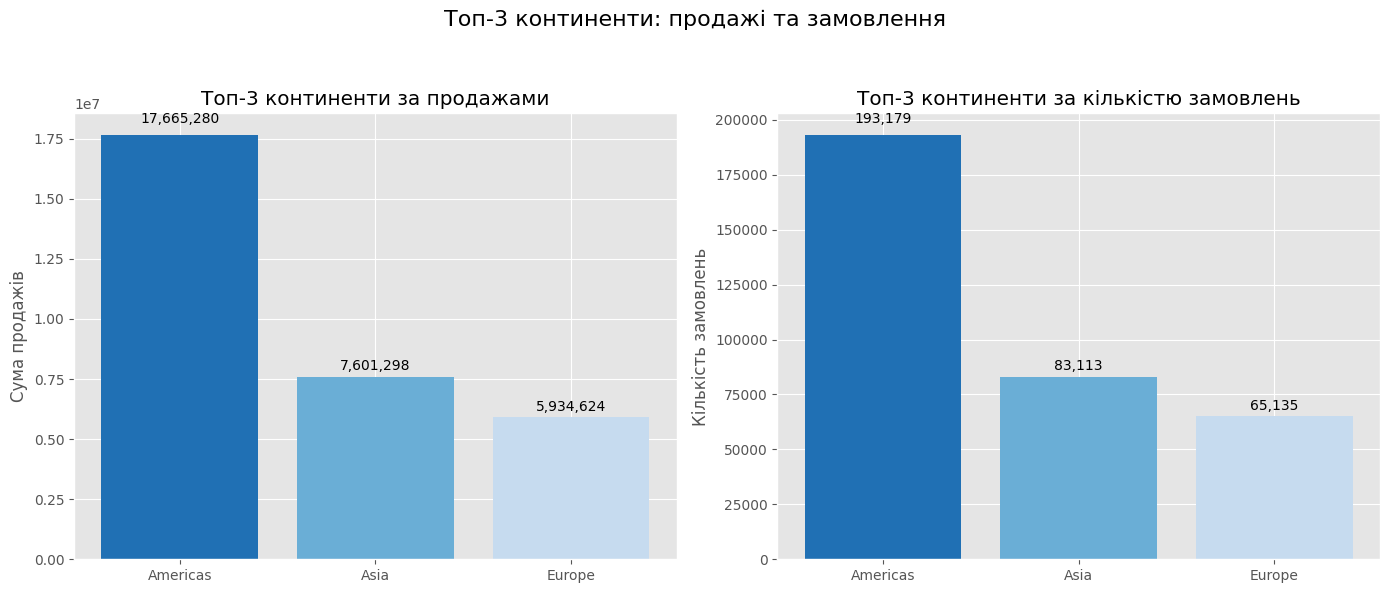

In [ ]:

# Стиль
plt.style.use('ggplot')

# Топ-3 континенти за продажами
top_continents_sales = df.groupby('continent')['price'].sum().sort_values(ascending=False).head(3)

# Топ-3 континенти за кількістю замовлень
top_continents_orders = df.groupby('continent')['ga_session_id'].nunique().sort_values(ascending=False).head(3)

# Кольори (інверсія м’яких блакитних відтінків)
sales_colors = sns.color_palette("Blues", n_colors=3)[::-1]
orders_colors = sns.color_palette("Blues", n_colors=3)[::-1]

# Візуалізація
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Топ-3 континенти: продажі та замовлення', fontsize=16)

# 🔹 Графік продажів
axes[0].bar(top_continents_sales.index, top_continents_sales.values, color=sales_colors)
axes[0].set_title('Топ-3 континенти за продажами')
axes[0].set_ylabel('Сума продажів')
axes[0].tick_params(axis='x', rotation=0)

# Підписи над барами
for i, v in enumerate(top_continents_sales.values):
    axes[0].text(i, v + v * 0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=10)

# 🔹 Графік замовлень
axes[1].bar(top_continents_orders.index, top_continents_orders.values, color=orders_colors)
axes[1].set_title('Топ-3 континенти за кількістю замовлень')
axes[1].set_ylabel('Кількість замовлень')
axes[1].tick_params(axis='x', rotation=0)

# Підписи над барами
for i, v in enumerate(top_continents_orders.values):
    axes[1].text(i, v + v * 0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=10)

# Завершення
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

**1. Americas — лідер за продажами та кількістю замовлень.**
- Продажі: 17,665,280 — більше ніж усі інші континенти разом.
- Замовлення: 193,179 — також найбільше.

**2. Азія — друге місце, але відставання помітне.**

- Сума продажів: 7,601,298 — у 2.3 рази менше, ніж Americas.
- Кількість замовлень: 83,113 — теж значно менше.

Це може свідчити або про нижчу купівельну спроможність, або про менш успішні маркетингові кампанії.

**3. Європа — найменші показники з трійки.**
- Сума продажів: 5,934,624.
- Замовлення: 65,135.

Europe показує найнижчі метрики. Варто дослідити причини: можливо, слабка локалізація продукту чи менша залученість користувачів.

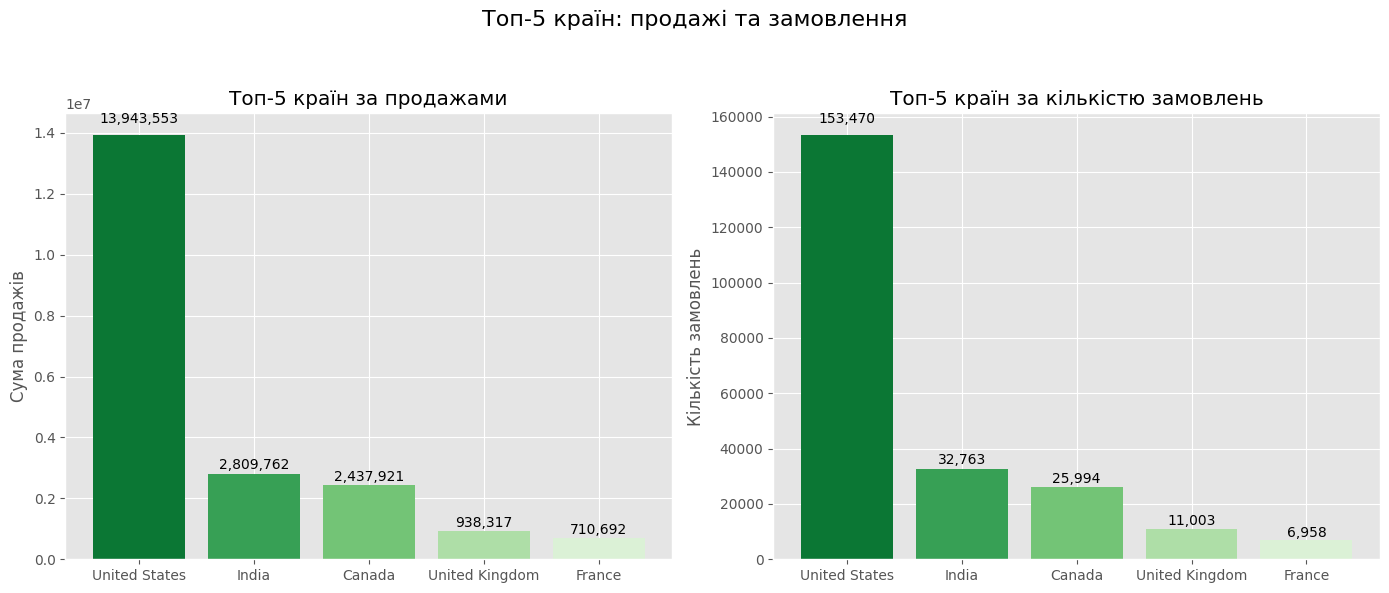

In [ ]:
plt.style.use('ggplot')

# Групування
top_countries_sales = df.groupby('country')['price'].sum().sort_values(ascending=False).head(5)
top_countries_orders = df.groupby('country')['ga_session_id'].nunique().sort_values(ascending=False).head(5)

# Зелена палітра з інверсією (темний — найбільше)
sales_colors = sns.color_palette("Greens", n_colors=5)[::-1]
orders_colors = sns.color_palette("Greens", n_colors=5)[::-1]

# Small Multiple — дві панелі
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Топ-5 країн: продажі та замовлення', fontsize=16)

# Продажі
axes[0].bar(top_countries_sales.index, top_countries_sales.values, color=sales_colors)
axes[0].set_title('Топ-5 країн за продажами')
axes[0].set_ylabel('Сума продажів')
axes[0].tick_params(axis='x', rotation=0)  # Прямий текст

# Підписи над стовпцями
for i, v in enumerate(top_countries_sales.values):
    axes[0].text(i, v + v * 0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=10)

# Замовлення
axes[1].bar(top_countries_orders.index, top_countries_orders.values, color=orders_colors)
axes[1].set_title('Топ-5 країн за кількістю замовлень')
axes[1].set_ylabel('Кількість замовлень')
axes[1].tick_params(axis='x', rotation=0)

# Підписи над стовпцями
for i, v in enumerate(top_countries_orders.values):
    axes[1].text(i, v + v * 0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

**1. США — абсолютний лідер.**
- Продажі: 13,943,553
- Замовлення: 153,470.

США генерують найбільші обсяги продажів і замовлень — понад 5 разів більше за найближчого конкурента (Індію).

Це свідчить про стабільний, платоспроможний ринок із високою конверсією.

2. **Індія — друге місце, але велике відставання.**
- Продажі: $2,809,762
- Замовлення: 32,763.

Хоча кількість замовлень досить висока, середній чек нижчий (≈$86). Це типовий патерн для ринку, де є великий обсяг трафіку, але нижча купівельна спроможність.

**3. Канада — схожий рівень з Індією за продажами.**
- Продажі: $2,437,921
- Замовлення: 25,994.

Менша кількість замовлень, але вищий середній чек (~$93.8) порівняно з Індією.

**4–5. Велика Британія та Франція — аутсайдери.**
- Продажі: $938,317 (UK), $710,692 (FR)
- Замовлення: 11,003 (UK), 6,958 (FR).

Низькі обсяги замовлень і продажів можуть свідчити про:
- меншу локальну присутність продукту;
- проблеми з доставкою/довірою;
- відсутність адаптованого маркетингу.

### **Топ-10 категорій товарів за загальною сумою продажів**

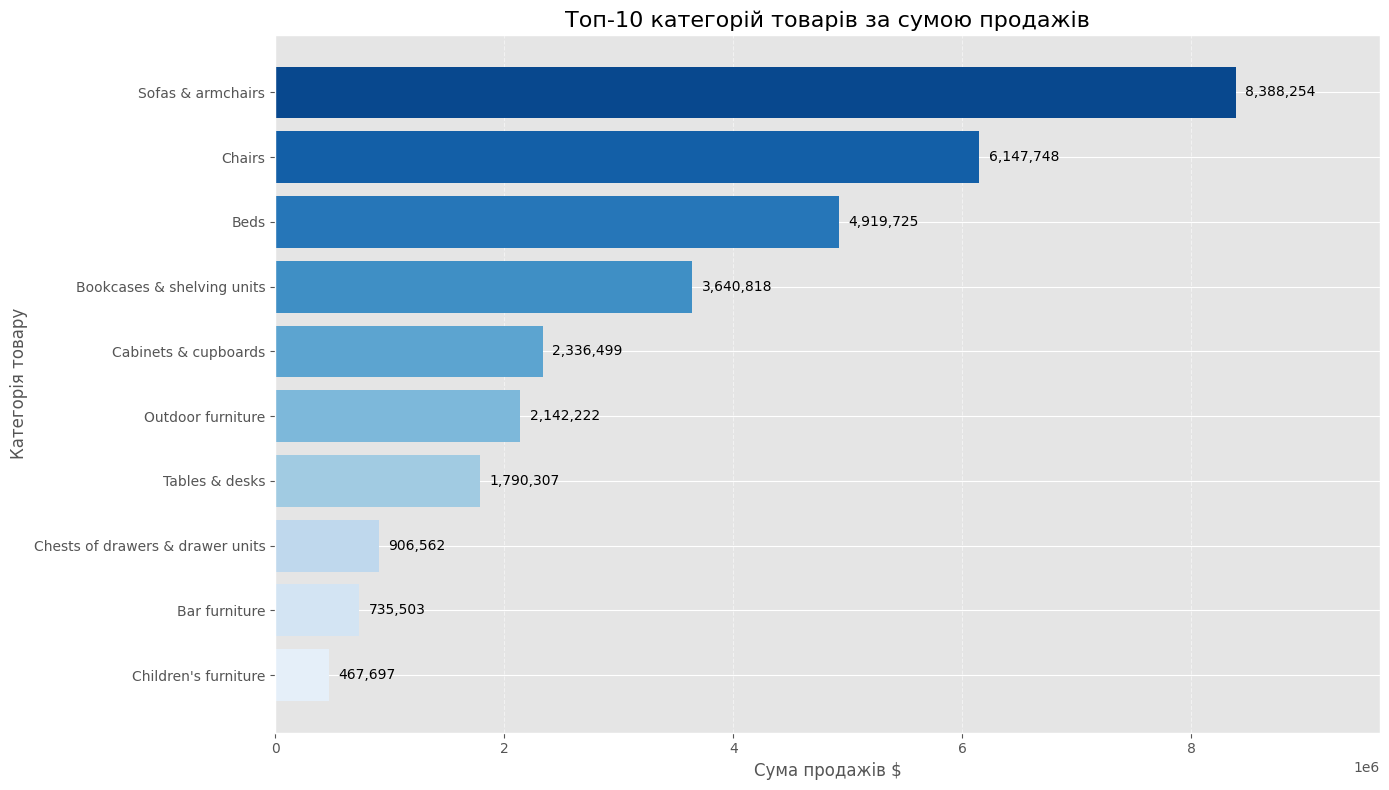

In [ ]:
# Стиль
plt.style.use('ggplot')

# Топ-10 категорій за сумою продажів
top_categories = (
    df.groupby('category')['price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Палітра (м’яка блакитна, темніше — більше)
colors = sns.color_palette("Blues", n_colors=10)[::-1]

# Візуалізація
plt.figure(figsize=(14, 8))
bars = plt.barh(top_categories.index, top_categories.values, color=colors)

# Підписи праворуч від барів
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max(top_categories.values) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f'{int(width):,}',
        ha='left', va='center', fontsize=10, color='black'
    )

# Оформлення
plt.title('Топ-10 категорій товарів за сумою продажів', fontsize=16)
plt.xlabel('Сума продажів $')
plt.ylabel('Категорія товару')
plt.gca().invert_yaxis()  # Найбільше вгорі
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, max(top_categories.values) * 1.15)
plt.tight_layout()
plt.show()

**1. Топ-3 категорії генерують левову частку доходу:**
- Sofas & armchairs: 8,388,254
- Chairs: 6,147,748
- Beds: 4,919,725

Разом ці 3 категорії формують понад 60% загальних продажів, тобто є основним драйвером виручки.

**2. Bookcases, Cabinets, Outdoor furniture — середній сегмент:**

Продаються помітно менше, але мають стабільний попит:
- Bookcases: 3.6M
- Cabinets: 2.3M
- Outdoor furniture: $2.1M

Потенціал для зростання — через сезонні кампанії або крос-продажі.

**3. Найслабші категорії — нішева пропозиція:**

- Children's furniture: 467,697
- Bar furniture: 735,503
- Chests of drawers: 906,562

Можуть мати високу маржу, але низький обсяг. Варто дослідити, чи варто їх розвивати, чи залишити як додаткові.

### **Топ-10 категорій товарів у країні з найбільшими продажами**

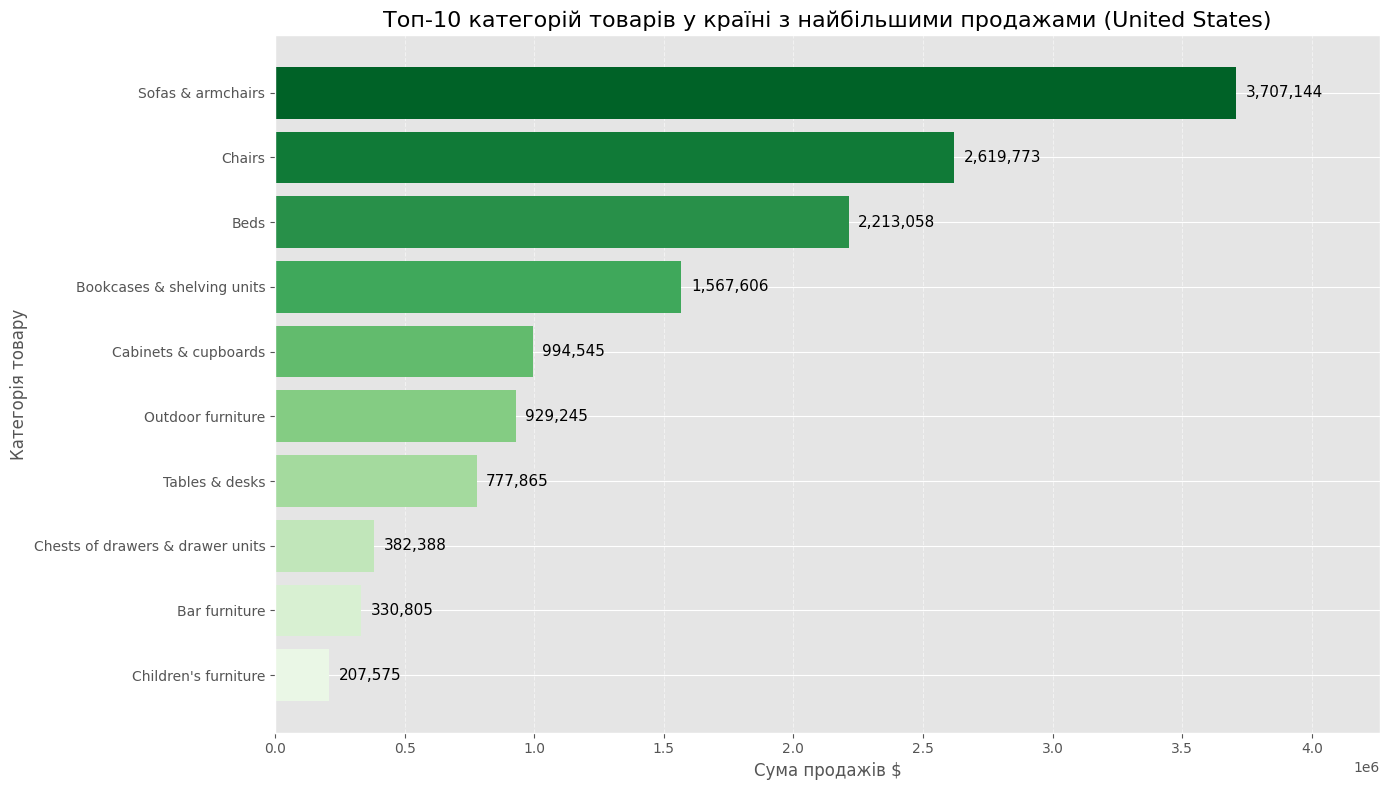

In [ ]:
# Країна з найбільшими продажами
top_country = df.groupby('country')['price'].sum().idxmax()
country_df = df[df['country'] == top_country]

# Топ-10 категорій
top_categories = (
    country_df.groupby('category')['price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Зелена палітра
colors = sns.color_palette("Greens", n_colors=10)[::-1]

# Фігура
plt.figure(figsize=(14, 8))
bars = plt.barh(top_categories.index, top_categories.values, color=colors)

# Підписи праворуч від барів
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max(top_categories.values) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{int(width):,}",
        ha='left', va='center',
        fontsize=11,
        color='black'
    )

# Оформлення
plt.title(f"Топ-10 категорій товарів у країні з найбільшими продажами ({top_country})", fontsize=16)
plt.xlabel("Сума продажів $", fontsize=12)
plt.ylabel("Категорія товару", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, max(top_categories.values) * 1.15)
plt.tight_layout()
plt.show()

**1. Структура лідерів зберігається.**

У США, як і загалом:
- 1 місце: Sofas & armchairs
- 2 місце: Chairs
- 3 місце: Beds

Це означає, що смаки споживачів у США відповідають глобальному тренду, і ці категорії є ключовими для масштабування.

**2. Відносна доля продажів у США — нижча.**

У глобальному графіку Sofas & armchairs мали 8.4M, а в США — лише 3.7M

Те ж саме по інших категоріях: частки менші, але порядок популярності зберігається.

Це логічно, адже США — найбільший ринок, але не єдиний.

Ситуація в США майже дзеркально відображає загальну тенденцію, що підтверджує:

Універсальність основних категорій.

Високу кореляцію між глобальним і локальним попитом.

 ### **Продажі у розрізі типів та моделей девайсів**

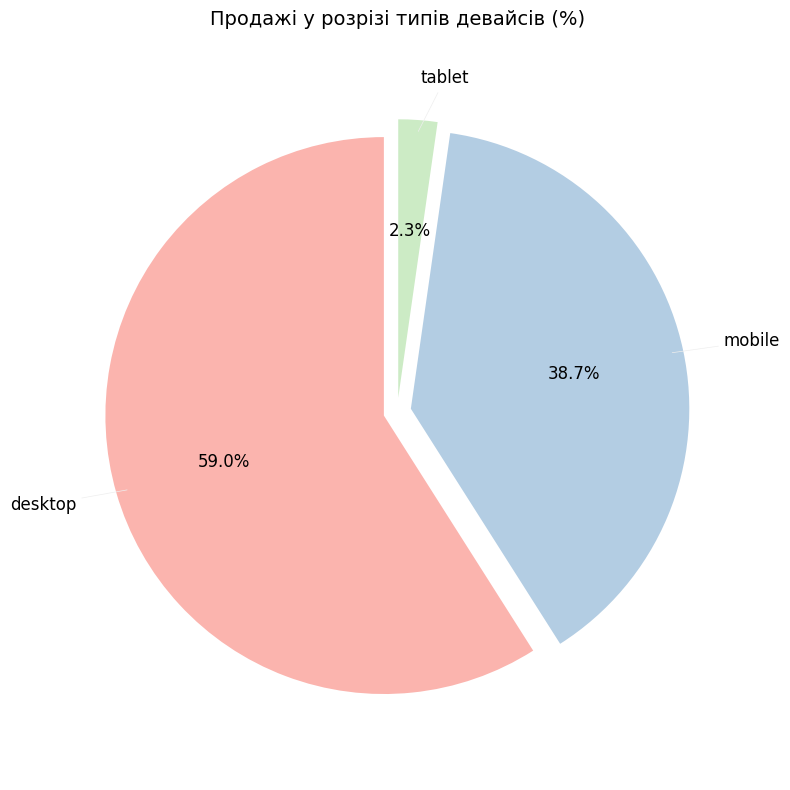

In [ ]:
# Загальна сума продажів
total_sales = df['price'].sum()

# Групування по типу девайсу
device_sales = df.groupby('device')['price'].sum().reset_index()
device_sales['percent_of_total_sales'] = (device_sales['price'] / total_sales) * 100
device_sales['percent_of_total_sales'] = device_sales['percent_of_total_sales'].round(2)

# Стиль
plt.style.use('ggplot')
colors = plt.cm.Pastel1.colors
explode = [0.05] * len(device_sales)

# Побудова без міток (ручне оформлення)
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    device_sales['percent_of_total_sales'],
    labels=[""] * len(device_sales),  # приховуємо стандартні мітки
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(device_sales)],
    explode=explode,
    textprops={'fontsize': 12}
)

# Ручне додавання міток типів
for i, (w, label) in enumerate(zip(wedges, device_sales['device'])):
    angle = (w.theta2 + w.theta1) / 2
    x = np.cos(np.radians(angle))
    y = np.sin(np.radians(angle))
    offset = 1.2
    ha = 'left' if x > 0 else 'right'
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(x * offset, y * offset),
        ha=ha,
        va='center',
        fontsize=12,
        arrowprops=dict(arrowstyle='-')
    )

# Оформлення
ax.axis('equal')
plt.title('Продажі у розрізі типів девайсів (%)', fontsize=14)
plt.tight_layout()
plt.show()

**1. Desktop — основне джерело прибутку.**

Майже дві третини продажів (59.0%) надходять із десктопів.

Це може свідчити про:
- зручність перегляду/оформлення замовлень на великих екранах,
- перевагу desktop для дорожчих або складніших покупок (напр. меблі, техніка).

 **2. Mobile — вагомий сегмент (38.7%).**

Понад третину продажів генерується з мобільних пристроїв.

Це високий показник, який підтверджує:
- популярність мобільного шопінгу,
- потребу в ідеальній мобільній адаптації.

 **3. Tablet — майже не використовується.**

Лише 2.3% продажів із планшетів.

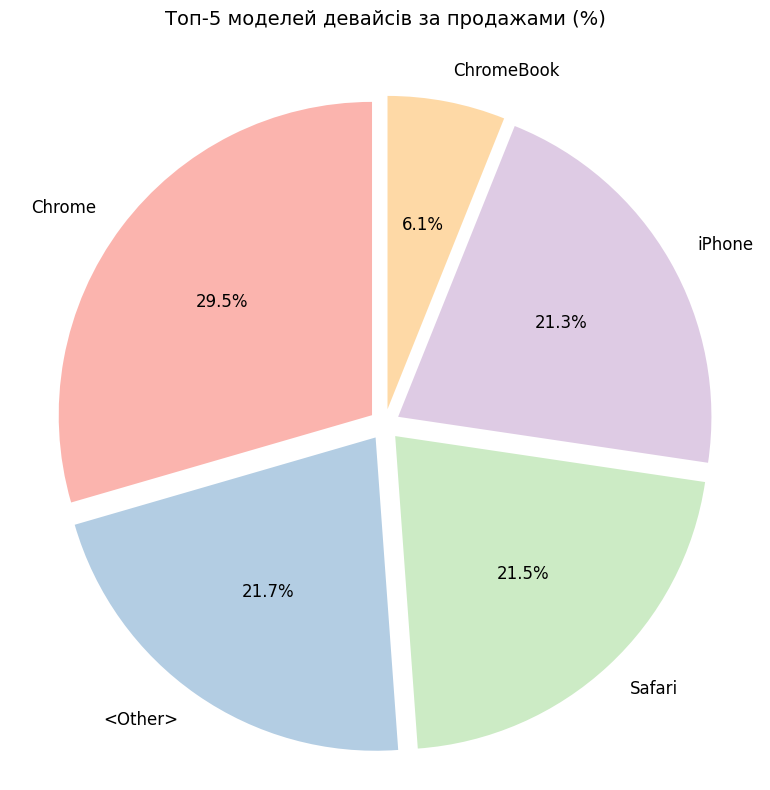

In [ ]:
# Обчислюємо загальну суму продажів
total_sales = df['price'].sum()

# Групуємо по моделях мобільних девайсів
model_sales = df.groupby('mobile_model_name')['price'].sum().reset_index()
model_sales['percent_of_total_sales'] = (model_sales['price'] / total_sales) * 100
model_sales = model_sales.sort_values(by='percent_of_total_sales', ascending=False)
model_sales['percent_of_total_sales'] = model_sales['percent_of_total_sales'].round(2)

# Беремо тільки топ-5 моделей
top_n = 5
top_models = model_sales.head(top_n)

# Стиль і палітра
plt.style.use('ggplot')
colors = plt.cm.Pastel1.colors
explode = [0.05] * top_n

# Побудова пайчарту з виправленням
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    top_models['percent_of_total_sales'],
    labels=top_models['mobile_model_name'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:top_n],
    explode=explode,
    textprops={'fontsize': 12},
    labeldistance=1.1  # трохи ближче до центру
)
ax.axis('equal')

plt.title('Топ-5 моделей девайсів за продажами (%)', fontsize=14, pad=30)  # pad додає відступ вниз

plt.subplots_adjust(top=0.88)  # нижче заголовок
plt.tight_layout()
plt.show()

Chrome є беззаперечним лідером серед моделей пристроїв за часткою продажів, з майже третиною всього обсягу (29.5%). Решта пристроїв мають приблизно однакові частки (близько 21%), окрім ChromeBook, який суттєво відстає.

### **Продажі за джерелами трафіку (у % від загальних продажів)**

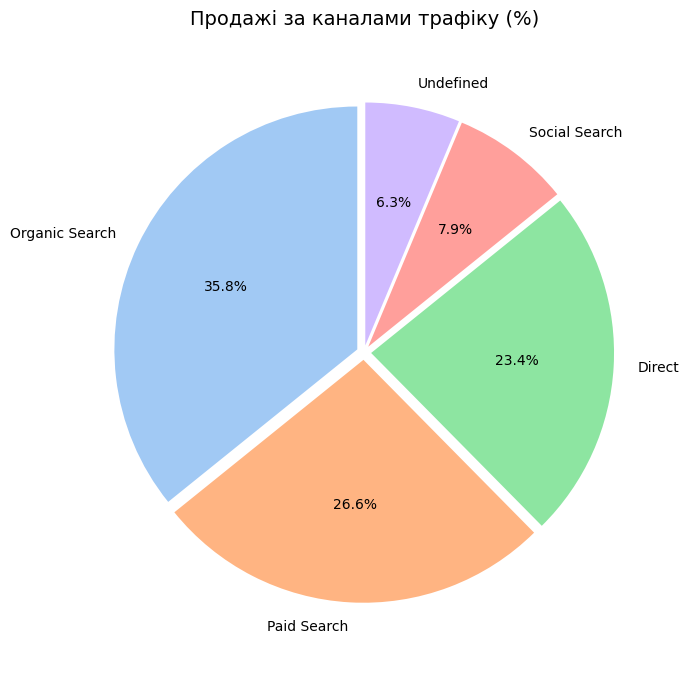

In [ ]:
# Загальна сума продажів
total_sales = df['price'].sum()

# Групування по каналах
channel_sales = (
    df.groupby('channel')['price']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Розрахунок відсотків
channel_sales['percent'] = (channel_sales['price'] / total_sales) * 100
channel_sales['percent'] = channel_sales['percent'].round(1)

# Візуалізація
plt.figure(figsize=(7, 7))
colors = sns.color_palette("pastel", len(channel_sales))
explode = [0.03] * len(channel_sales)  # злегка відокремити всі сегменти

plt.pie(
    channel_sales['percent'],
    labels=channel_sales['channel'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode
)

plt.title('Продажі за каналами трафіку (%)', fontsize=14)
plt.axis('equal')  # кругла форма
plt.tight_layout()
plt.show()

**1. Organic Search — головний канал прибутку.**

Майже 4 з 10 продажів приходять із безкоштовного пошукового трафіку.

**2. Paid Search також приносить чимало.**

Платний пошук генерує понад чверть продажів (26.6%).

**3. Direct трафік теж вагомий.**

23.4% — майже кожен 4-й продаж — із людей, що ввели сайт напряму або зберегли в закладки.

**4. Social Search — поки слабка ланка.**

Лише 7.9% продажів із соцмереж.

### **Знайдемо який відсоток зареєстрованих користувачів підтвердив свою електронну адресу**

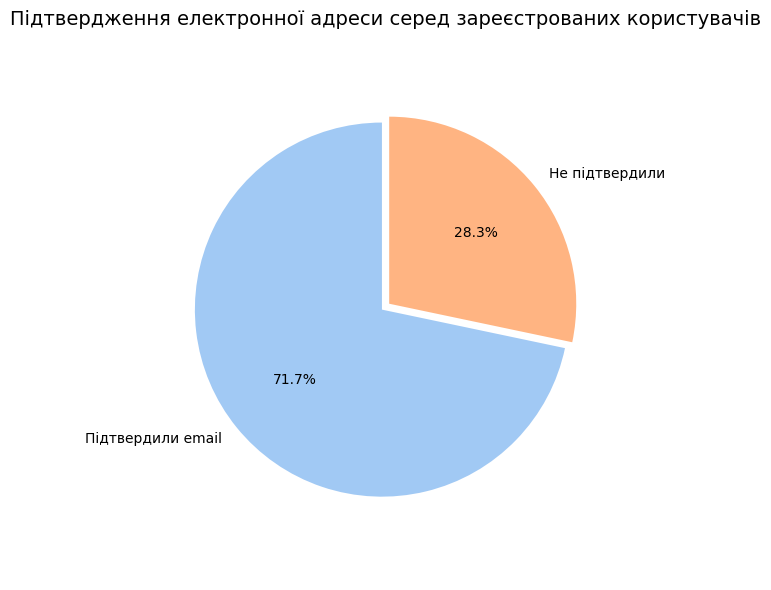

In [ ]:
# Фільтруємо зареєстрованих користувачів
registered_users = df[df['account_id'].notna()]

# Враховуємо лише тих, хто має is_verified = 1 або 0
verifiable_users = registered_users[registered_users['is_verified'].isin([0, 1])]

# Рахуємо кількість підтверджених / не підтверджених
verified_count = (verifiable_users['is_verified'] == 1).sum()
not_verified_count = (verifiable_users['is_verified'] == 0).sum()

# Дані для графіка
labels = ['Підтвердили email', 'Не підтвердили']
sizes = [verified_count, not_verified_count]
colors = sns.color_palette("pastel")[0:2]
explode = [0.05, 0]  # Легкий акцент на перший сектор

# Побудова пайчарту
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode
)

# Оформлення
plt.title('Підтвердження електронної адреси серед зареєстрованих користувачів', fontsize=14)
plt.axis('equal')  # кругла форма
plt.tight_layout()
plt.show()

Бачимо, що 71.7 % зареєстрованих користувачів підтвердили свою електронну адресу.

### **Знайдемо який відсоток зареєстрованих користувачів відписався від розсилки**


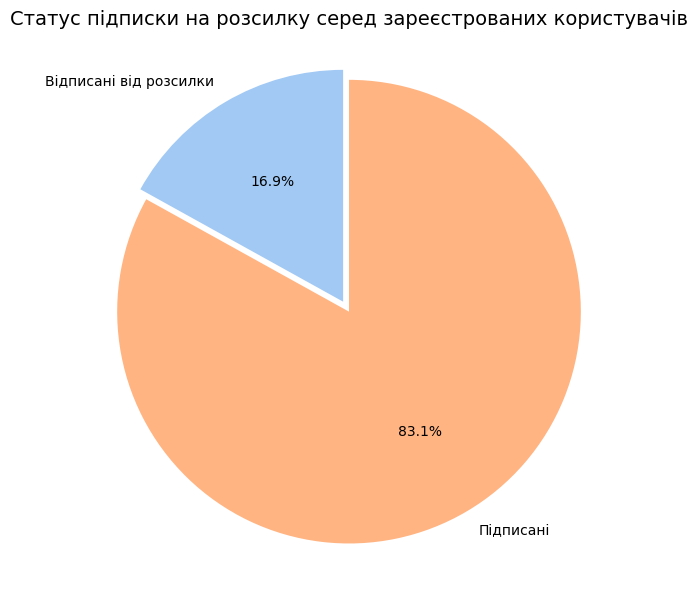

In [ ]:
# Фільтруємо зареєстрованих користувачів
registered_users = df[df['account_id'].notna()]

# Ті, у кого явно вказано статус розсилки (0 або 1)
unsubscribable_users = registered_users[registered_users['is_unsubscribed'].isin([0, 1])]

# Підрахунок
unsubscribed_count = (unsubscribable_users['is_unsubscribed'] == 1).sum()
subscribed_count = (unsubscribable_users['is_unsubscribed'] == 0).sum()

# Дані для графіка
labels = ['Відписані від розсилки', 'Підписані']
sizes = [unsubscribed_count, subscribed_count]
colors = sns.color_palette("pastel")[0:2]
explode = [0.05, 0]  # Відокремимо сектор "відписані"

# Побудова пайчарту
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode
)

# Оформлення
plt.title('Статус підписки на розсилку серед зареєстрованих користувачів', fontsize=14)
plt.axis('equal')  # для круглої форми
plt.tight_layout()
plt.show()

Бачимо, що 16.9 % зареєстрованих користувачів відписалися від розсилки.

### **Проаналізуємо чи відрізняється поведінка (у плані продажів) тих, хто відписався від розсилки та тих, хто досі підписаний**

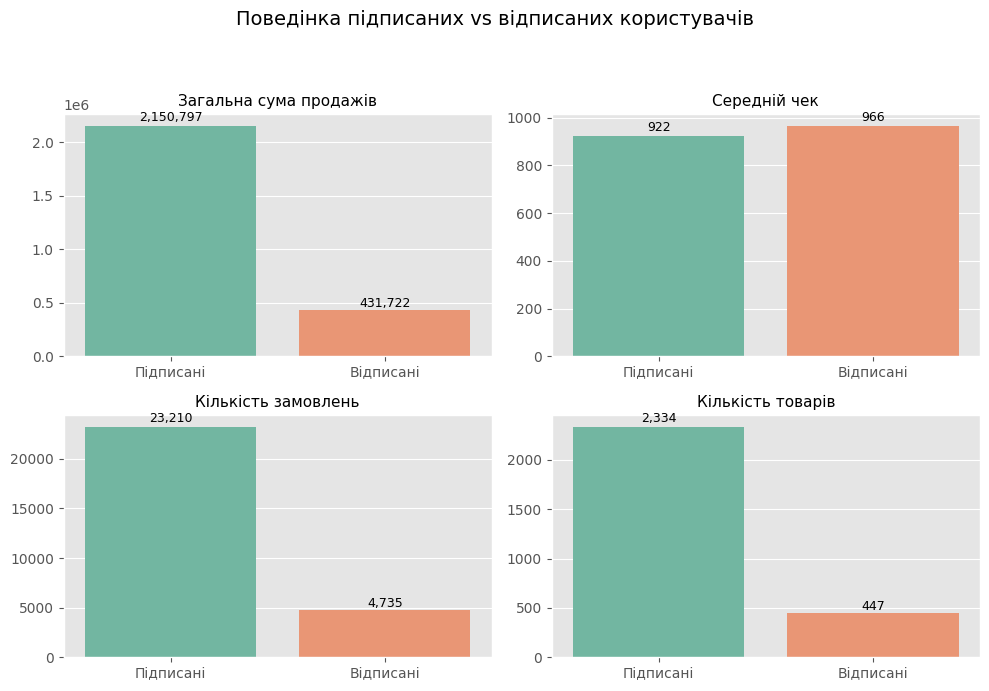

In [ ]:
# Групування
filtered_users = df[df['is_unsubscribed'].isin([0, 1]) & df['account_id'].notna()]
behavior_summary = filtered_users.groupby('is_unsubscribed').agg(
    total_sales=('price', 'sum'),
    avg_order_value=('price', 'mean'),
    total_orders=('ga_session_id', 'nunique'),
    total_items=('price', 'count')
).reset_index()

behavior_summary['is_unsubscribed'] = behavior_summary['is_unsubscribed'].map({
    0: 'Підписані', 1: 'Відписані'
})

# Компактні графіки
metrics = ['total_sales', 'avg_order_value', 'total_orders', 'total_items']
titles = ['Загальна сума продажів', 'Середній чек', 'Кількість замовлень', 'Кількість товарів']
colors = sns.color_palette("Set2", 2)

fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # трохи менше
fig.suptitle('Поведінка підписаних vs відписаних користувачів', fontsize=14)

for ax, metric, title in zip(axes.flat, metrics, titles):
    sns.barplot(
        data=behavior_summary,
        x='is_unsubscribed',
        y=metric,
        hue='is_unsubscribed',
        palette=colors,
        legend=False,
        ax=ax
    )
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('')
    for i, val in enumerate(behavior_summary[metric]):
        ax.text(i, val * 1.01, f'{val:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


**Висновки:**

- підписані користувачі приносять у ~5 разів більше виручки;
- підписані користувачі роблять більше покупок;
- підписані купують не лише частіше, а й більше одиниць товарів за замовлення;
- але середній чек більший у відписаних. Можливо відписані купують рідко, але дорого. Висновок: стратегія для них має бути інша — одиничні, але вигідні пропозиції.

Підписані користувачі — ключовий сегмент, що забезпечує більшість продажів, замовлень і товарів. Вони значно активніші та цінніші у довгостроковій перспективі, хоча середній чек трохи нижчий.


### **Проаналізуємо в яких країнах (топ-10) найбільше зареєстрованих користувачів**

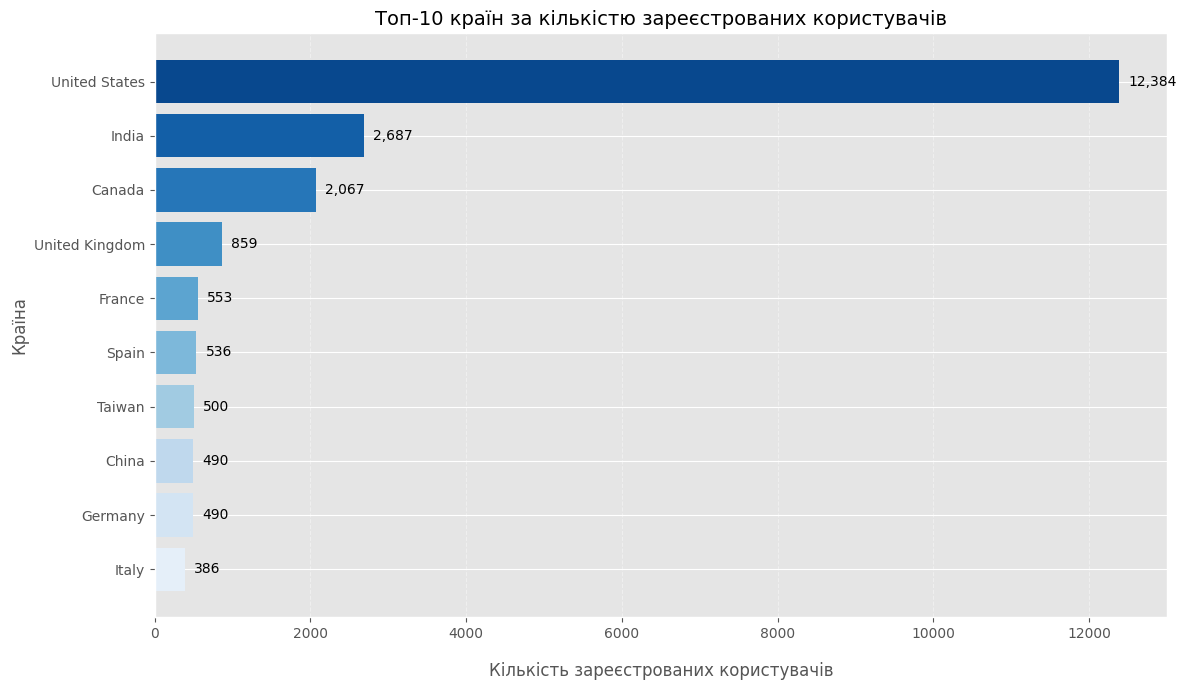

In [ ]:
# Фільтруємо зареєстрованих користувачів
registered_users = df[df['account_id'].notna()]

# Топ-10 країн за унікальними account_id
top_countries = (
    registered_users.groupby('country')['account_id']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

# Колірна палітра
colors = sns.color_palette("Blues", n_colors=10)[::-1]

# Побудова графіка
plt.figure(figsize=(12, 7))
bars = plt.barh(top_countries.index, top_countries.values, color=colors)

# Підписи біля барів, праворуч
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max(top_countries.values)*0.01,  # трохи правіше від бару
        bar.get_y() + bar.get_height() / 2,
        f'{int(width):,}',
        ha='left',
        va='center',
        fontsize=10,
        color='black'
    )

# Оформлення
plt.title('Топ-10 країн за кількістю зареєстрованих користувачів', fontsize=14)
plt.xlabel('Кількість зареєстрованих користувачів', labelpad=15)  # більший відступ підпису осі X
plt.ylabel('Країна')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**1. США — абсолютний лідер.**

12,384 користувачі — це майже в 5 разів більше, ніж друге місце (Індія).

Це основний ринок, що вже забезпечує масштабну базу користувачів.

**2. Індія та Канада — другорядні, але стабільні ринки.**

Разом — ~4.7 тис. користувачів

Індія — показує великий обсяг з потенціалом до зростання. Канада — класичний англомовний ринок з високим ARPU.

**3. Європейські країни (UK, FR, ES, DE, IT) мають слабку присутність.**

Жодна не перевищує 1 тис. користувачів

Видно, що тут ще не було масової експансії або відчутної локалізації.

**4. Китай, Тайвань — мінімальна присутність, потенційно через бар'єри.**

Лише ~500 користувачів

Ці ринки складні через мовні, культурні, технічні та регуляторні бар'єри.

Рекомендація: або ігнорувати їх на початкових етапах масштабування, або працювати через локальних партнерів.

# Аналіз динаміки продажів

### **Знайдемо загальні продажі за кожну дату та створимо візуалізацію загальної динаміки продажів**

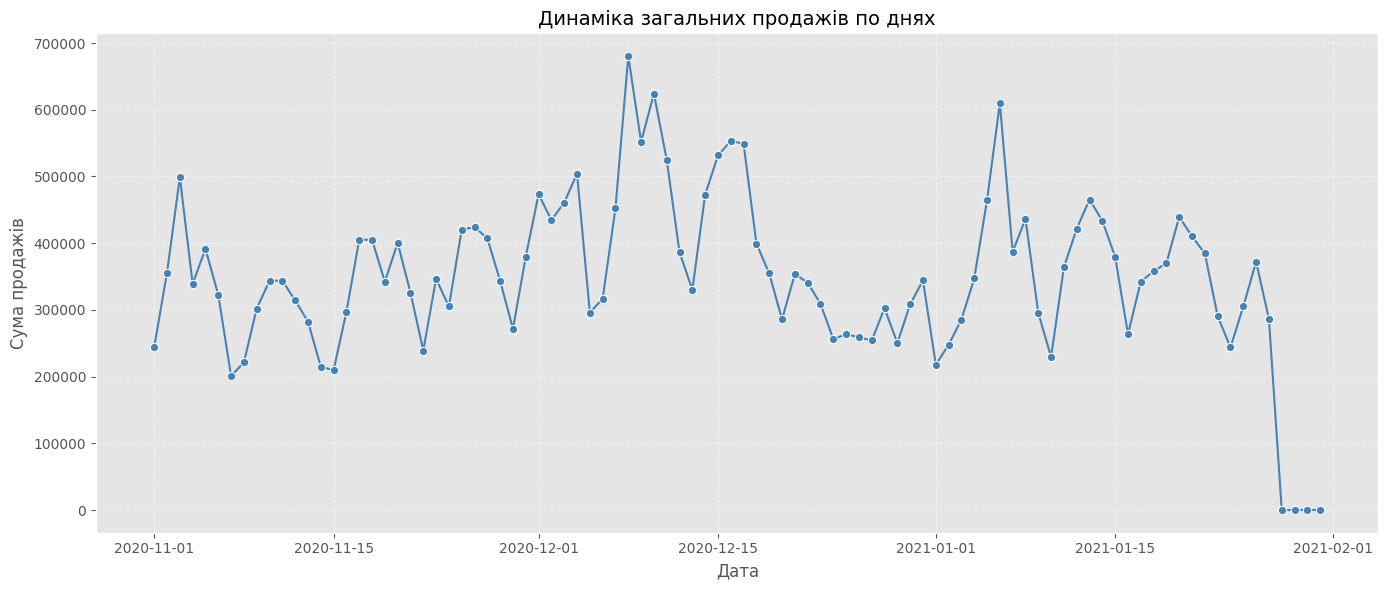

In [ ]:
#  Групування по даті
daily_sales = (
    df.groupby('date')['price']
    .sum()
    .reset_index()
    .sort_values('date')
)

# Побудова графіка
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sales, x='date', y='price', marker='o', color='steelblue')

# Оформлення
plt.title('Динаміка загальних продажів по днях', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сума продажів', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

**1. Сезонний сплеск у грудні**.

Найвищі піки (~680,000) спостерігаються в середині грудня.

Це класична поведінка ринку під час передноворічних покупок (подарунки, акції, розпродажі).

Пік активності: 2020-12-12 → 2020-12-17.

**2. Післясвяткове просідання**.

Після 20 грудня йде чітке зниження загальної динаміки:
- Часті "провали" нижче 300,000
- Повільне відновлення в перших числах січня

Це очікувана післясвяткова пауза, коли:
- Покупці менш активні
- Бюджети вичерпані
- Часто бувають повернення.

**3. Різкий сплеск у січні.**

Приблизно 2021-01-05–07 — новий пік, близько 610,000.

Ймовірна причина — післяноворічні розпродажі або маркетингова активація.


### **Проаналізуємо чи спостерігається сезонність продажів**

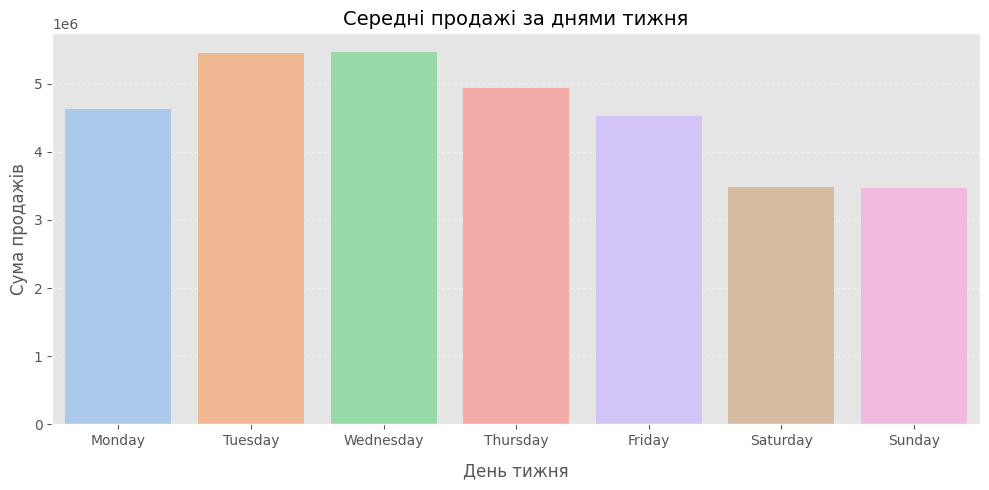

In [ ]:
# Додати колонку з днем тижня (без нового перетворення дати)
df['day_of_week'] = df['date'].dt.day_name()

# Встановити порядок днів
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Групування і сортування
weekly_sales = df.groupby('day_of_week', as_index=False)['price'].sum()
weekly_sales['day_of_week'] = pd.Categorical(weekly_sales['day_of_week'], categories=day_order, ordered=True)
weekly_sales = weekly_sales.sort_values('day_of_week')

# Візуалізація
plt.figure(figsize=(10, 5))
sns.barplot(
    data=weekly_sales,
    x='day_of_week',
    y='price',
    hue='day_of_week',
    palette='pastel',
    legend=False
)

plt.title('Середні продажі за днями тижня', fontsize=14)
plt.ylabel('Сума продажів')
plt.xlabel('День тижня', labelpad=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**1. Найвищі продажі припадають на вівторок та середу:**
- це свідчить, що покупці найактивніше здійснюють покупки на початку тижня, особливо в середині робочих днів;
- середа — пік активності.

**2. Продажі знижуються ближче до вихідних:**
- субота та неділя мають найменші суми продажів;
- це може свідчити про зниження онлайн-активності у вихідні, або ж те, що рішення про покупку приймається в будні.

**3. Початок і кінець робочого тижня (понеділок, пʼятниця) — мають середні показники, але все ж нижчі за середу/вівторок.**

Продажі мають чітко виражену тижневу сезонність, із піками у вівторок–середу та спадами у вихідні.

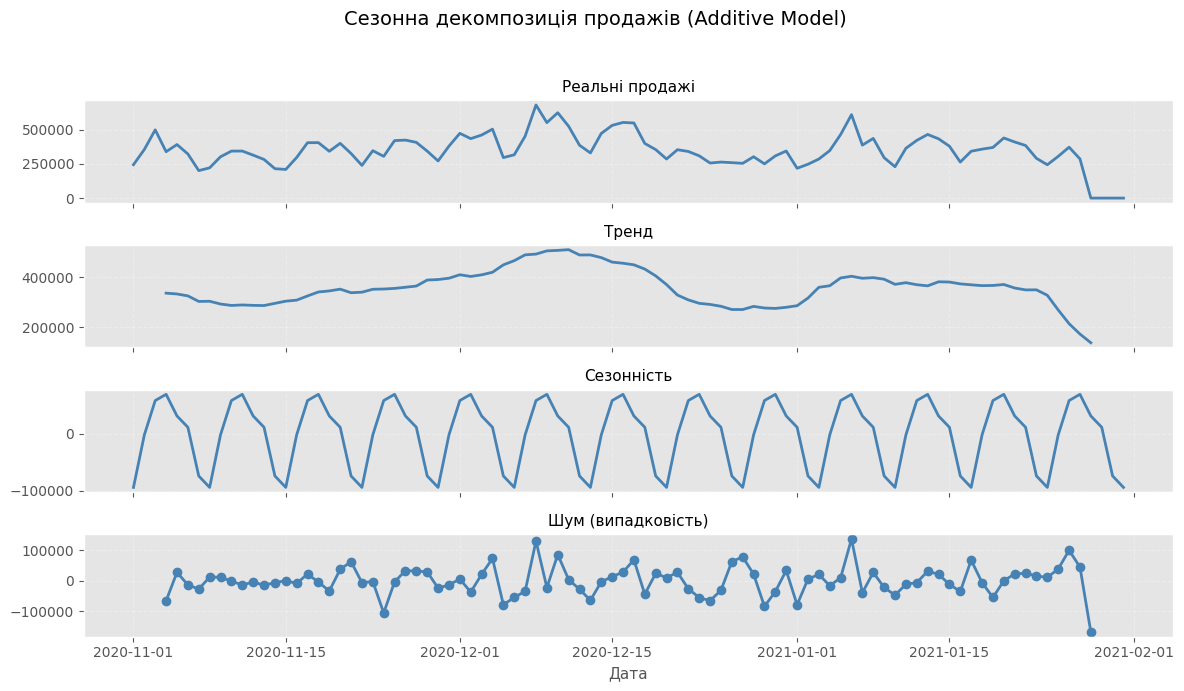

In [ ]:
# Сумарні щоденні продажі
daily_sales = df.groupby('date')['price'].sum().sort_index()
daily_sales.index = pd.to_datetime(daily_sales.index, format='%Y%m%d')
daily_sales = daily_sales.asfreq('D').fillna(0)

# Сезонна декомпозиція
decomposition = seasonal_decompose(daily_sales, model='additive')

# Візуалізація (менший розмір графіка)
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

# Назви та компоненти
titles = ['Реальні продажі', 'Тренд', 'Сезонність', 'Шум (випадковість)']
components = [
    decomposition.observed,
    decomposition.trend,
    decomposition.seasonal,
    decomposition.resid
]

# Побудова кожного блоку
for ax, comp, title in zip(axes, components, titles):
    ax.plot(comp, color='steelblue', linewidth=2, marker='o' if title == 'Шум (випадковість)' else None)
    ax.set_title(title, fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

# Заголовок
plt.suptitle('Сезонна декомпозиція продажів (Additive Model)', fontsize=14)
plt.xlabel('Дата', fontsize=11)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**1. Тренд**:

Впевнене зростання з початку листопада до ~середини грудня

Це підтверджує сезонні покупки перед святами

Потім — зниження в кінці грудня – січні

Спад після свят, очікувана фаза "охолодження"
- різке падіння наприкінці січня — це або:
реальне зменшення,
- або відсутність/втрата даних (дуже підозріле різке обвалення тренду — перевірити!)

Тренд підтверджує класичну сезонну поведінку з піком у грудні.

**2. Сезонність:**

Яскраво виражена тижнева періодичність (7 днів):
- рівномірний малюнок, регулярні підйоми й спади
типово для e-commerce: піки у вихідні або на старт робочого тижня

Амплітуда ~±100,000 грн

Є стабільна повторювана поведінка, яку можна прогнозувати.

**3. Шум (випадковість):**

Більшість точок коливається в межах ±50–80 тис.

Але є кілька різких стрибків/падінь — наприклад:
- ~2020-12-10 (сплеск)
- ~2021-01-30 (різкий мінус — ймовірна втрата даних або збій)

Останні точки шуму — підозріло “мінусові”, що також свідчить про:

Наявність нульових/відсутніх продажів у кінці січня → це не бізнес-поведінка, а можливо — технічна проблема.

Продажі мають виражену сезонну структуру з тижневими коливаннями та потужним передноворічним зростанням. Після свят — спад, а наприкінці січня — різке обвалення, найімовірніше через відсутність або втрату даних.




### **Проаналізуємо динаміку продажів в Америці, Азії та Європі**

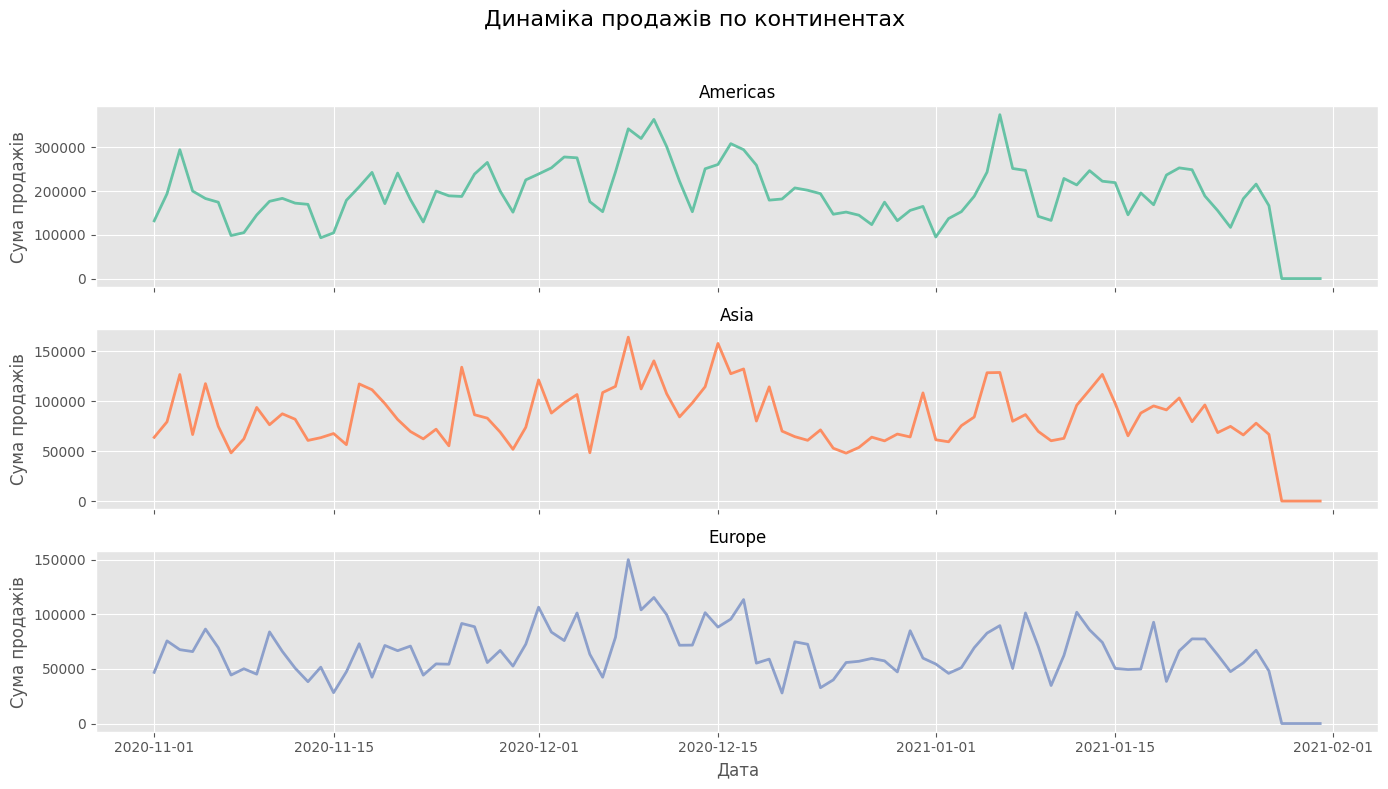

In [ ]:
# Стиль ggplot
plt.style.use('ggplot')

# Вибір трьох континентів
continents = ['Americas', 'Asia', 'Europe']
df_filtered = df[df['continent'].isin(continents)]

# Групування продажів по даті і континенту
sales_by_date_continent = (
    df_filtered.groupby(['continent', 'date'])['price']
    .sum()
    .reset_index()
)

# Кольори для кожного континенту
palette = sns.color_palette("Set2", n_colors=3)
continent_colors = dict(zip(continents, palette))

# Смол Малтіплс: одна вісь X з підписами лише знизу
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8), sharex=True)
fig.suptitle("Динаміка продажів по континентах", fontsize=16)

for ax, continent in zip(axes, continents):
    data = sales_by_date_continent[sales_by_date_continent['continent'] == continent]
    sns.lineplot(data=data, x='date', y='price', ax=ax, color=continent_colors[continent], linewidth=2)
    ax.set_title(continent, fontsize=12)
    ax.set_ylabel("Сума продажів")
    if continent != 'Europe':
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)
    else:
        ax.set_xlabel("Дата", fontsize=12)
        ax.tick_params(axis='x', labelrotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**1. America = основний рушій продажів.**

Продажі регулярно перевищують 200,000, з піками до >350,000 грн/день

Стабільна сезонна структура: підйоми у грудні та після Нового року

Різке обнулення в самому кінці січня — можлива втрата даних

**Висновок:** ринок Америки — ключовий. Тут найбільший обсяг та стабільність.

**2. Asia = помірний, але активний ринок.**

Сума продажів переважно в межах 60–130 тис. грн/день

Більше "зубців" — тобто часті перепади

Помітні локальні піки в грудні (~15.12) та січні (~10.01)

**Висновок:** ринок Азії менш стабільний, але має регулярні активні періоди — особливо в акції/свята.

**3. Europe = найнижча динаміка.**

Продажі рідко перевищують 100,000 грн/день

Графік найбільш "шумний" — без яскраво вираженого тренду

Попри це, у грудні видно 1–2 сплески

Висновок: Європа — найменш активний континент, з нестабільними результатами. Потрібна стратегія локального залучення.


 **4. Аномалія: повне падіння до 0 у всіх регіонах після 2021-01-28.**

Це не звичайна сезонність.

Всі 3 регіони синхронно = 0 — це майже гарантована відсутність даних або збій





### **Проаналізуємо динаміку продажів у розрізі каналів трафіку**

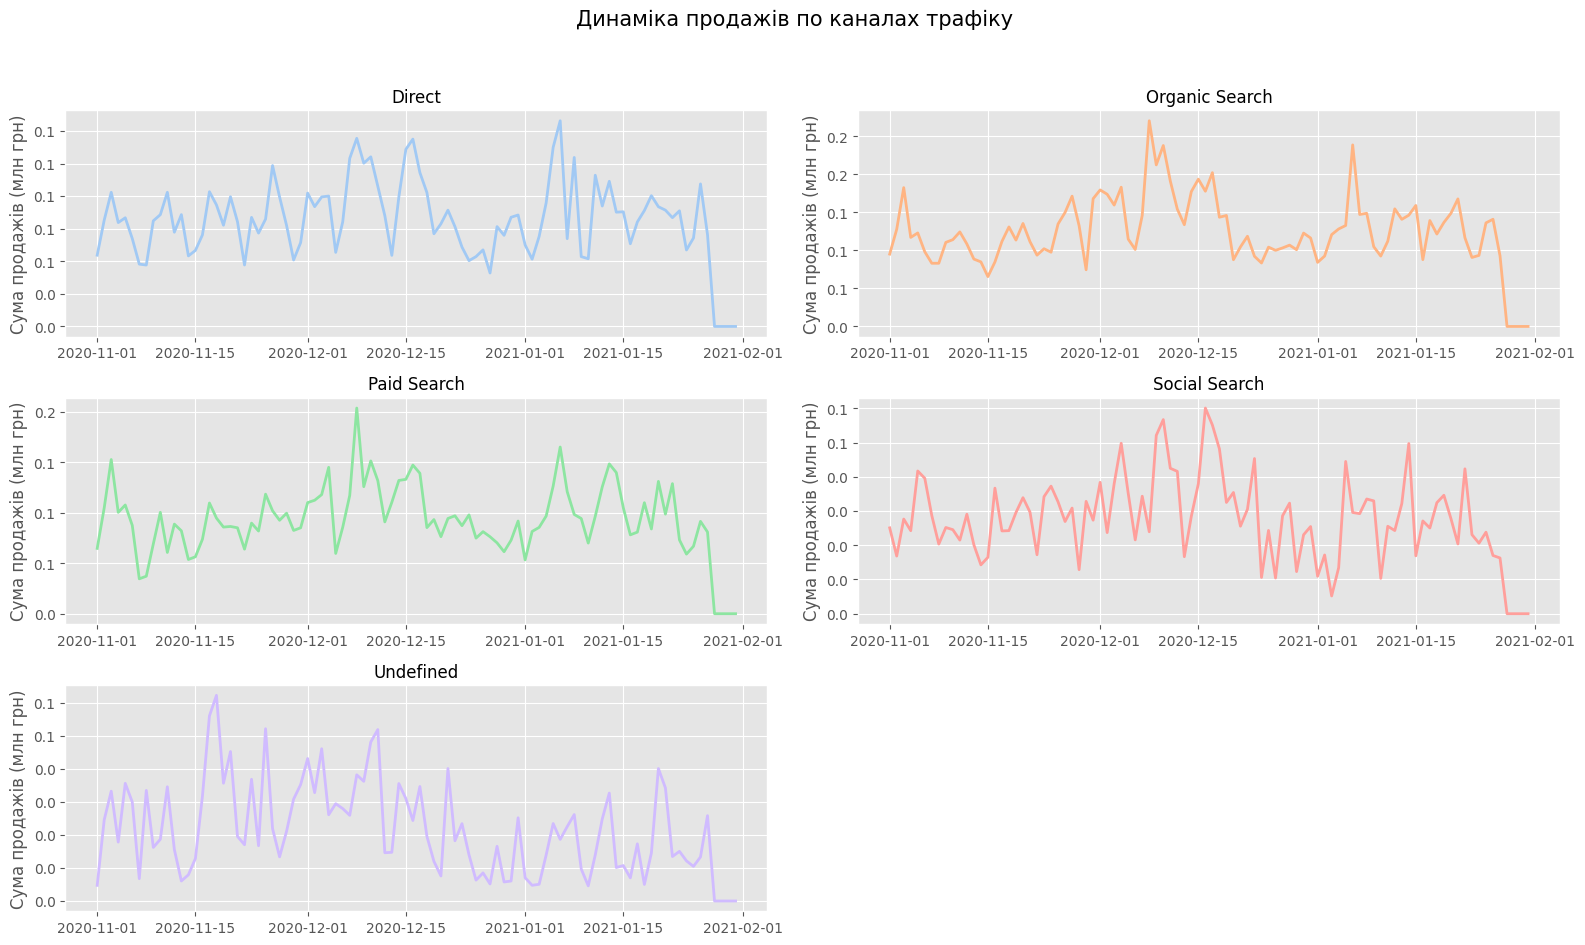

In [ ]:
# Стиль
plt.style.use('ggplot')

# Групування: щоденні продажі по каналах
channel_sales = (
    df.groupby(['channel', 'date'])['price']
    .sum()
    .reset_index()
)

# Унікальні канали
channels = channel_sales['channel'].dropna().unique()
n_channels = len(channels)

# Пастельна палітра
colors = sns.color_palette("pastel", n_colors=n_channels)

# Розміри сітки
n_cols = 2
n_rows = (n_channels + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3.2), sharex=False)
axes = axes.flatten()

# Побудова графіків
for i, (channel, color) in enumerate(zip(channels, colors)):
    ax = axes[i]
    subset = channel_sales[channel_sales['channel'] == channel]

    ax.plot(subset['date'], subset['price'], color=color, linewidth=2)
    ax.set_title(channel, fontsize=12)
    ax.set_ylabel("Сума продажів (млн грн)")

    # Формат осі Y
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))

    # Форматування дати
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', labelrotation=0)

# Видалити порожні підграфіки
for j in range(n_channels, len(axes)):
    fig.delaxes(axes[j])

# Заголовок і форматування
fig.suptitle("Динаміка продажів по каналах трафіку", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**1. Organic Search — найбільш стабільний і продуктивний канал.**

Часто перевищує 0.1 млн грн

Має найвищі пікові значення (~0.25 млн грн) у грудні та січні

Сезонність відчутна, але канал працює весь період.

**2. Direct — сильний, але з великими коливаннями.**

Продажі часто коливаються від 0.05 до 0.15 млн грн

Сплески на початку січня → можливо, ефект емейл-кампаній або повторних покупок.

**3. Paid Search — рівномірно середній канал.**

Присутня стабільна база (~0.05–0.12 млн грн), але без яскравих піків

Активність рівномірна → ймовірно, кампанії працювали без змін.

**4. Social Search — висока волатильність.**

Часті сплески, але й просідання до нуля

Є сильні піки на середині грудня та січня.

**5. Undefined — найменш надійний.**

Слабка і нерегулярна динаміка, часто = 0

Можливо, це непарсені або непромарковані сесії

### **Проаналізуємо динаміку продажів у розрізі типів девайсів**

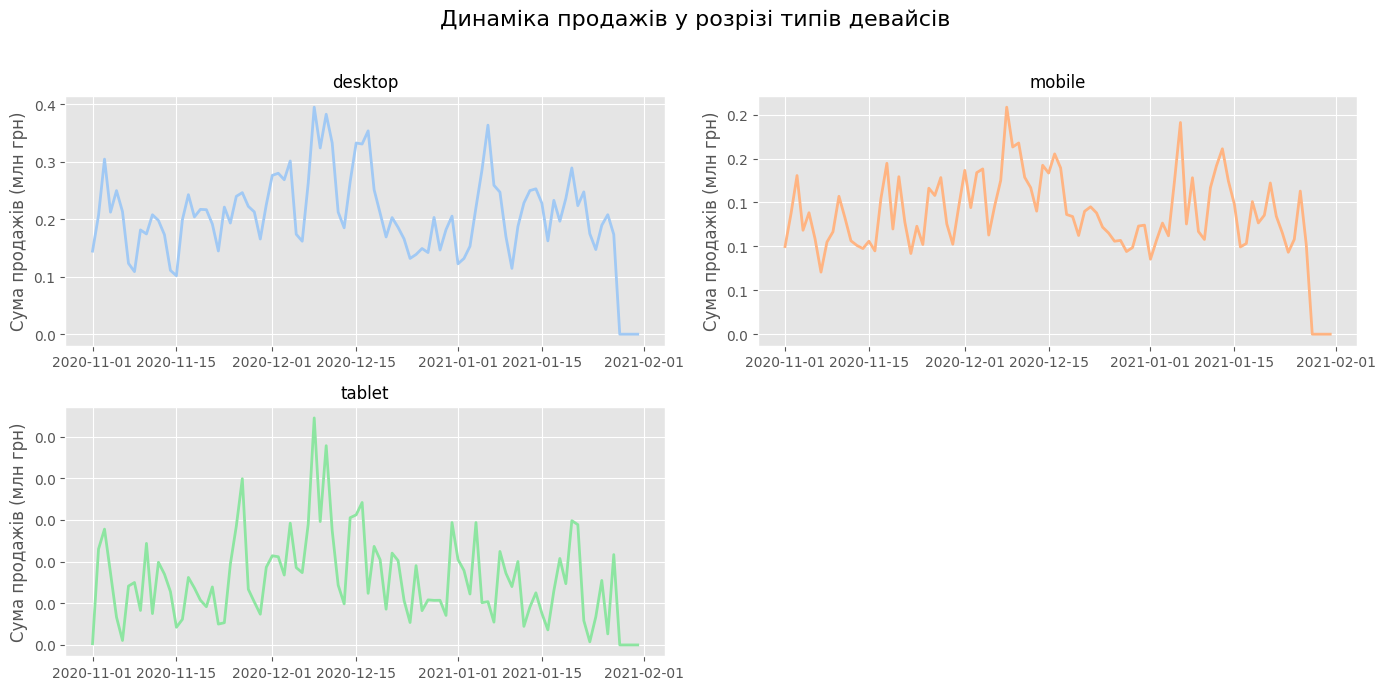

In [ ]:
# Стиль
plt.style.use('ggplot')

# Групування: щоденні продажі за типами девайсів
device_sales = (
    df.groupby(['device', 'date'])['price']
    .sum()
    .reset_index()
)

# Унікальні девайси
devices = device_sales['device'].dropna().unique()
n_devices = len(devices)

# Палітра пастельна
colors = sns.color_palette("pastel", n_colors=n_devices)

# Параметри підграфіків
n_cols = 2
n_rows = (n_devices + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5), sharex=False)
axes = axes.flatten()

# Побудова графіків
for i, (device, color) in enumerate(zip(devices, colors)):
    ax = axes[i]
    subset = device_sales[device_sales['device'] == device]

    ax.plot(subset['date'], subset['price'], color=color, linewidth=2)
    ax.set_title(device, fontsize=12)
    ax.set_ylabel("Сума продажів (млн грн)")

    # Формат осі Y у мільйонах
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x / 1e6:.1f}'))

    # Прямі дати (горизонтальні)
    ax.tick_params(axis='x', labelrotation=0)

# Видалення порожніх підграфіків
for j in range(n_devices, len(axes)):
    fig.delaxes(axes[j])

# Заголовок і форматування
fig.suptitle("Динаміка продажів у розрізі типів девайсів", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**1. Desktop — домінуючий канал продажів.**

Продажі найвищі серед усіх типів пристроїв: регулярно ~0.2–0.4 млн грн/день

Яскраві піки:

~2020-12-10 і ~2021-01-05 — майже 0.45 млн

Має чітку стабільну структуру зі сезонним зростанням у грудні

Післясвяткове зниження, але рівень лишається найвищим.

**2. Mobile — другий за значенням канал.**

Продажі вдвічі нижчі, ніж у desktop: ~0.1–0.2 млн грн

Вища частота піків, особливо в середині грудня й січні

Більша "нерівність" кривої: користувачі активні, але менш стабільні.

**3. Tablet — маргінальний канал.**

Дуже слабка активність: переважно <0.05 млн грн/день

Декілька незначних піків у грудні (~0.1 млн), далі просідання

Часто взагалі відсутні продажі.

# Зведені таблиці

### **Зведена таблиця, яка показує кількість сесій у розрізі каналів трафіку та типів девайсів**

In [ ]:
# Фільтрація: виключаємо пропущені значення у важливих полях
filtered_df = df.dropna(subset=['channel', 'device', 'ga_session_id'])

# Створення зведеної таблиці
pivot_table = (
    filtered_df
    .groupby(['channel', 'device'])['ga_session_id']
    .nunique()  # рахуємо кількість унікальних сесій
    .reset_index()
    .pivot(index='channel', columns='device', values='ga_session_id')
    .fillna(0)  # заповнюємо порожні комірки нулями
    .astype(int)  # конвертуємо значення в int
)

display(pivot_table)


device,desktop,mobile,tablet
channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Undefined,12527,8486,470


### **Створимо зведену таблицю, яка показує загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)**

In [ ]:
# Визначаємо топ-10 категорій за обсягом продажів
top_categories = (
    df.groupby('category')['price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Визначаємо топ-5 країн за обсягом продажів
top_countries = (
    df.groupby('country')['price']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Фільтруємо дані лише по топ категоріях і країнах
filtered_df = df[
    df['category'].isin(top_categories) &
    df['country'].isin(top_countries)
]

# Зведена таблиця: сума продажів
pivot_table = (
    filtered_df
    .groupby(['category', 'country'])['price']
    .sum()
    .reset_index()
    .pivot(index='category', columns='country', values='price')
    .fillna(0)  # якщо в якійсь комбінації немає даних
)

# Опціонально округлення для краси
pivot_table = pivot_table.round(0).astype(int)

# Показати зведену таблицю
display(pivot_table)

country,Canada,France,India,United Kingdom,United States
category,,,,,
Bar furniture,51724,11199,57657,22103,330805
Beds,354772,116414,358320,133816,2213058
Bookcases & shelving units,278982,73830,364507,113988,1567607
Cabinets & cupboards,181802,59102,191888,71684,994546
Chairs,417741,134029,544309,188519,2619774
Chests of drawers & drawer units,71952,21544,73111,36784,382388
Children's furniture,30264,14258,39177,13348,207575
Outdoor furniture,185323,40486,162289,57002,929245
Sofas & armchairs,692428,187735,788430,234812,3707144


### **Побудуємо зведену таблицю, яка показує суму продажів у розрізі каналів трафіку та континентів**

In [ ]:
# Видаляємо пропущені значення у критичних колонках
filtered_df = df.dropna(subset=['channel', 'continent', 'price'])

# Створюємо зведену таблицю: Сума продажів по каналах та континентах
pivot_table = pd.pivot_table(
    filtered_df,
    values='price',
    index='channel',
    columns='continent',
    aggfunc='sum',
    fill_value=0  # якщо немає продажів у комбінації — 0
)

# Опціонально округлення для краси
pivot_table = pivot_table.round(0).astype(int)

# Виводимо зведену таблицю
display(pivot_table)

continent,(not set),Africa,Americas,Asia,Europe,Oceania
channel,,,,,,
Direct,21443,70028,4222962,1755294,1343094,82102
Organic Search,15080,129908,6294563,2725954,2154139,113508
Paid Search,19931,88195,4627454,2039256,1620206,116006
Social Search,11224,31188,1384428,576032,498507,30727
Undefined,6389,11912,1135873,504762,318678,22887


### **Побудуємо зведену таблицю, яка показує середній чек (середня ціна) по категоріях і типах девайсів**

In [ ]:
# Фільтруємо пропуски у важливих колонках
filtered_df = df.dropna(subset=['category', 'device', 'price'])

# Створюємо зведену таблицю: Середній чек по категоріях і типах девайсів
avg_check_pivot = pd.pivot_table(
    filtered_df,
    values='price',
    index='category',
    columns='device',
    aggfunc='mean',
    fill_value=0  # якщо не було жодного продажу — ставимо 0
)
# Опціонально округлення для краси
avg_check_pivot = avg_check_pivot.round(0).astype(int)


# Виводимо результат
display(avg_check_pivot)

device,desktop,mobile,tablet
category,,,
Bar furniture,669,686,583
Beds,1709,1646,1613
Bookcases & shelving units,480,474,468
Cabinets & cupboards,1002,1007,1202
Café furniture,386,373,725
Chairs,1059,984,1187
Chests of drawers & drawer units,627,618,668
Children's furniture,276,270,320
Nursery furniture,382,326,374


# Статистичний аналіз взаємозв’язків

### **Знайдемо кількість сесій та загальні продажі за кожну дату. Створимо візуалізацію, щоб побачити взаємозв’язок між цими метриками. Дамо відповідь на питання: чи корелюють ці показники? А також знайдемо відповідний коефіцієнт кореляції та проаналізуємо його статистичну значущість**

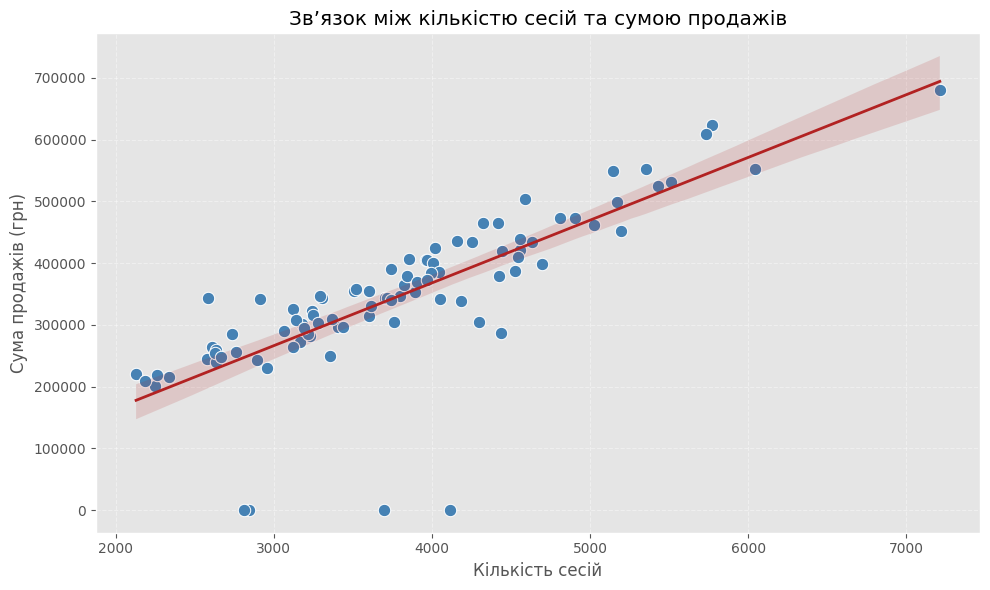

In [ ]:
# Групування: кількість сесій та сума продажів по кожній даті
daily_stats = df.groupby('date').agg(
    total_sessions=('ga_session_id', 'nunique'),
    total_sales=('price', 'sum')
).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=daily_stats,
    x='total_sessions',
    y='total_sales',
    color='steelblue',
    s=80
)

sns.regplot(
    data=daily_stats,
    x='total_sessions',
    y='total_sales',
    scatter=False,
    color='firebrick',
    line_kws={"linewidth": 2}
)

plt.title('Зв’язок між кількістю сесій та сумою продажів')
plt.xlabel('Кількість сесій')
plt.ylabel('Сума продажів (грн)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
# Розрахунок
corr_coef, p_value = pearsonr(daily_stats['total_sessions'], daily_stats['total_sales'])

# Вивід
print(f'Коефіцієнт кореляції Пірсона: {corr_coef:.3f}')
print(f'p-value: {p_value:.4f}')

Коефіцієнт кореляції Пірсона: 0.791
p-value: 0.0000


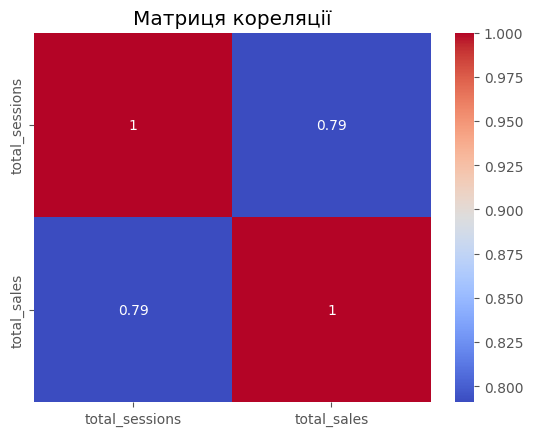

In [ ]:
sns.heatmap(daily_stats[['total_sessions', 'total_sales']].corr(), annot=True, cmap='coolwarm')
plt.title('Матриця кореляції')
plt.show()

**1. Сильна позитивна кореляція:**

Коефіцієнт 0.791 — це сильна лінійна залежність (за шкалою Пірсона: 0.7 – 0.9 = сильна).

Це означає: чим більше користувачів заходить (сесій), тим більше вони купують.

**2. Статистична значущість:**

p-value = 0.0000 (тобто < 0.001) — результат є надзвичайно значущим.

Ми відкидаємо нульову гіпотезу, тобто зв'язок між сесіями і продажами не випадковий.

Залучення більшої кількості користувачів напряму впливає на зростання продажів.

Це може свідчити про:
- ефективну воронку продажів;
- хорошу конверсію трафіку;
- відсутність перешкод у покупці.

### **Проаналізуємо чи корелюють між собою продажі на різних континентах. Візьмемо топ-3 континенти. Проаналізуємо статистичну значущість взаємозв’язків.**

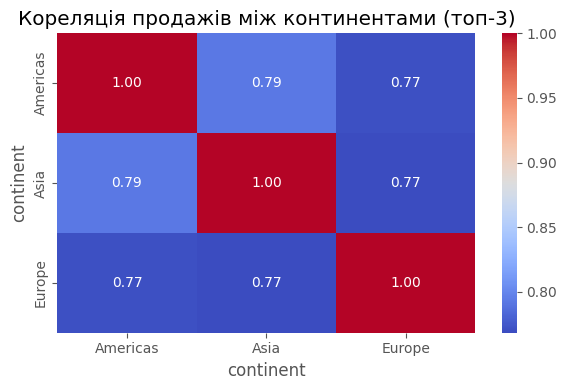

Статистична значущість кореляцій (p-value):
Americas vs Asia: r = 0.79, p = 0.0000 ✅ статистично значуща кореляція (p < 0.05)
Americas vs Europe: r = 0.77, p = 0.0000 ✅ статистично значуща кореляція (p < 0.05)
Asia vs Europe: r = 0.77, p = 0.0000 ✅ статистично значуща кореляція (p < 0.05)


In [ ]:
# 1. Топ-3 континенти за загальними продажами
top_continents = df.groupby('continent')['price'].sum().nlargest(3).index.tolist()

# 2. Групування: сума продажів по кожній даті для кожного з топ-3 континентів
grouped = (
    df[df['continent'].isin(top_continents)]
    .groupby(['date', 'continent'])['price']
    .sum()
    .reset_index()
)

# 3. Pivot-таблиця: дати по рядках, континенти по стовпцях
pivot = grouped.pivot(index='date', columns='continent', values='price').dropna()

# 4. Обчислення кореляційної матриці методом Пірсона
corr_matrix = pivot.corr(method='pearson')

# 5. Візуалізація heatmap з підписами
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Кореляція продажів між континентами (топ-3)')
plt.tight_layout()
plt.show()

# 6. Обчислення p-value для кожної унікальної пари континентів
print("Статистична значущість кореляцій (p-value):")
seen = set()
for col1 in pivot.columns:
    for col2 in pivot.columns:
        if col1 != col2 and (col2, col1) not in seen:
            r, p = pearsonr(pivot[col1], pivot[col2])
            print(f"{col1} vs {col2}: r = {r:.2f}, p = {p:.4f}", end=' ')
            if p < 0.05:
                print("✅ статистично значуща кореляція (p < 0.05)")
            else:
                print("❌ незначуща кореляція (p ≥ 0.05)")
            seen.add((col1, col2))

Аналіз щоденних продажів між трьома провідними континентами (Америка, Європа, Азія) виявив сильні позитивні кореляції (r ≈ 0.77–0.79), всі з яких є статистично значущими (p < 0.001). Це свідчить про високий ступінь узгодженості поведінки споживачів у глобальному масштабі. Такий результат вказує на ефективність синхронних маркетингових стратегій та відкриває перспективи для побудови єдиної моделі прогнозування продажів для кількох регіонів.

### **Дослідимо чи корелюють між собою продажі за різними каналами трафіку. Проаналізуємо статистичну значущість взаємозв’язків.**


In [ ]:
# Групування: сума продажів по каналах трафіку на кожну дату
channel_sales_daily = (
    df.dropna(subset=['channel'])  # виключаємо NaN
      .groupby(['date', 'channel'])['price']
      .sum()
      .reset_index()
)

# Переходимо до wide-form для кореляції
channel_pivot = channel_sales_daily.pivot(index='date', columns='channel', values='price').fillna(0)


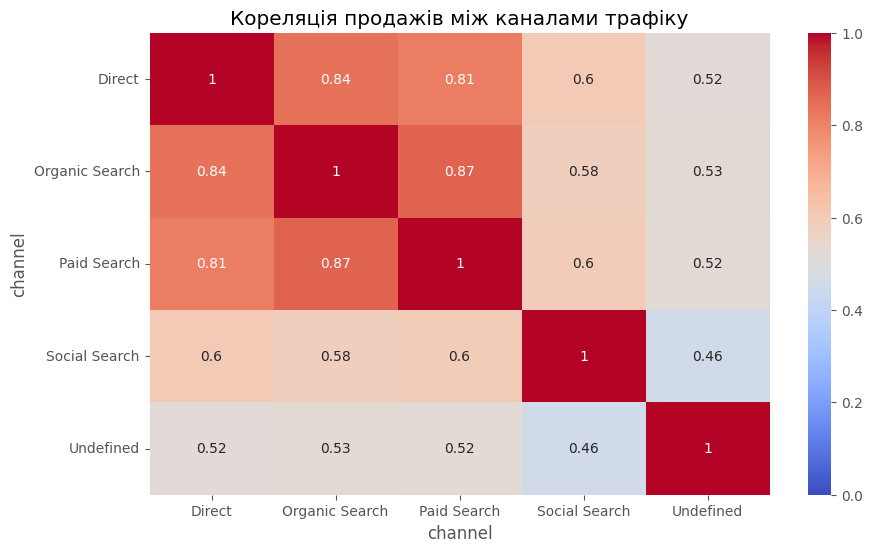

In [ ]:
# Матриця кореляції Пірсона
corr_matrix = channel_pivot.corr()

# Візуалізація
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Кореляція продажів між каналами трафіку')
plt.show()

In [ ]:
# Статистична значущість (p-value)
channels = channel_pivot.columns
results = []

for i in range(len(channels)):
    for j in range(i + 1, len(channels)):
        ch1, ch2 = channels[i], channels[j]
        r, p = pearsonr(channel_pivot[ch1], channel_pivot[ch2])
        results.append({
            'Канал 1': ch1,
            'Канал 2': ch2,
            'Коефіцієнт кореляції (r)': round(r, 2),
            'p-value': f"{p:.4f}"
        })

# Вивід результатів
correlation_df = pd.DataFrame(results).sort_values(by='Коефіцієнт кореляції (r)', ascending=False)
correlation_df

,Канал 1,Канал 2,Коефіцієнт кореляції (r),p-value
4,Organic Search,Paid Search,0.87,0.0000
0,Direct,Organic Search,0.84,0.0000
1,Direct,Paid Search,0.81,0.0000
2,Direct,Social Search,0.60,0.0000
7,Paid Search,Social Search,0.60,0.0000
5,Organic Search,Social Search,0.58,0.0000
6,Organic Search,Undefined,0.53,0.0000
3,Direct,Undefined,0.52,0.0000
8,Paid Search,Undefined,0.52,0.0000
9,Social Search,Undefined,0.46,0.0000


Найвищий зв’язок зафіксовано між основними джерелами (Organic Search, Paid Search, Direct) із коефіцієнтами Пірсона від 0.81 до 0.87 (усі p < 0.001), що свідчить про їхню синхронну поведінку та потенційно мультиканальну природу користувачів.

Social Search показує помірні кореляції (r ≈ 0.58–0.60), що вказує на часткову синхронізацію з основними каналами, однак із більш незалежною динамікою. Канал Undefined має найменші кореляції, що потребує окремого аналізу щодо джерел даних.


### Дослідимо чи корелюють між собою продажі за топ-5 категоріями товарів та проаналізуємо статистичну значущість взаємозв’язків

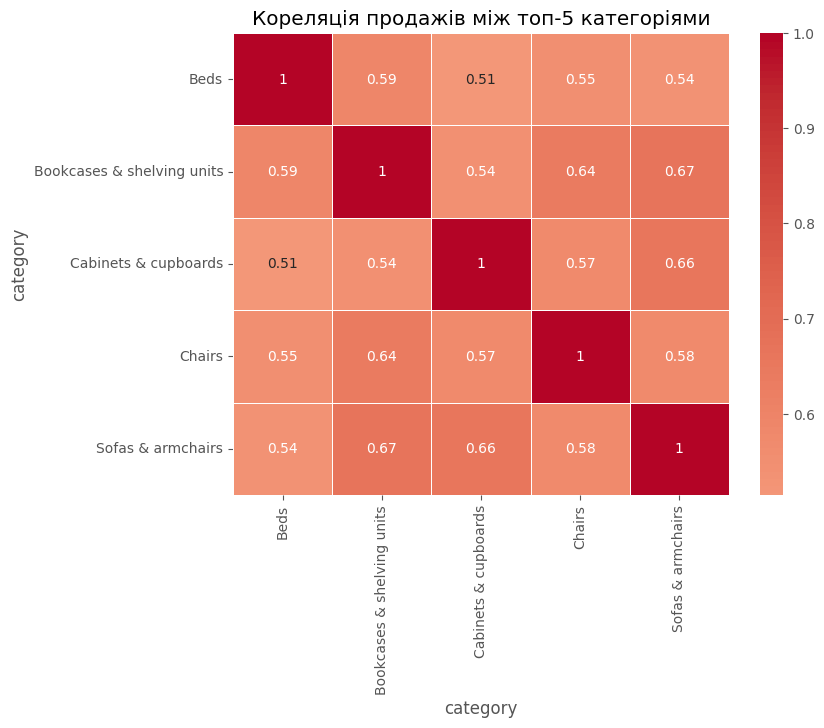

In [ ]:
top5_categories = (
    df.groupby('category')['price']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

category_daily_sales = (
    df[df['category'].isin(top5_categories)]
    .groupby(['date', 'category'])['price']
    .sum()
    .reset_index()
    .pivot(index='date', columns='category', values='price')
)

correlation_matrix = category_daily_sales.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Кореляція продажів між топ-5 категоріями")
plt.show()


In [ ]:

# Всі пари категорій
pairs = list(itertools.combinations(top5_categories, 2))

# Обчислимо коефіцієнти кореляції
correlation_results = []
for cat1, cat2 in pairs:
    series1 = category_daily_sales[cat1].dropna()
    series2 = category_daily_sales[cat2].dropna()

    # Синхронізація по датах
    aligned = pd.concat([series1, series2], axis=1).dropna()
    r, p = pearsonr(aligned[cat1], aligned[cat2])

    correlation_results.append({
        'Категорія 1': cat1,
        'Категорія 2': cat2,
        'Коефіцієнт кореляції (r)': round(r, 2),
        'p-value': round(p, 4)
    })

# Виведення результату
correlation_df = pd.DataFrame(correlation_results)
display(correlation_df)

,Категорія 1,Категорія 2,Коефіцієнт кореляції (r),p-value
0,Sofas & armchairs,Chairs,0.58,0.0
1,Sofas & armchairs,Beds,0.54,0.0
2,Sofas & armchairs,Bookcases & shelving units,0.67,0.0
3,Sofas & armchairs,Cabinets & cupboards,0.66,0.0
4,Chairs,Beds,0.55,0.0
5,Chairs,Bookcases & shelving units,0.64,0.0
6,Chairs,Cabinets & cupboards,0.57,0.0
7,Beds,Bookcases & shelving units,0.59,0.0
8,Beds,Cabinets & cupboards,0.51,0.0
9,Bookcases & shelving units,Cabinets & cupboards,0.54,0.0


Найвищі кореляції виявлено між м’якими меблями (Sofas & armchairs) та товарами для зберігання (Bookcases, Cabinets) — коефіцієнти Пірсона 0.66–0.67, що вказує на часту спільну купівлю.
Категорія Beds демонструє лише помірний зв’язок із рештою (r ≈ 0.51–0.59), що може свідчити про незалежну купівельну поведінку.
Усі виявлені кореляції є статистично значущими (p < 0.001), що дозволяє використовувати ці зв’язки для побудови моделей прогнозування попиту або формування категорійного маркетингу.


# Статистичний аналіз відмінностей між групами

### **Проаналізуємо продажі за кожну дату зареєстрованих та незареєстрованих користувачів. Створимо відповідні вибірки, проаналізуємо розподіли даних в обох вибірках. Підберемо відповідний статистичний тест для порівняння вибірок. Зробимо висновок щодо статистичної значущості отриманих результатів**

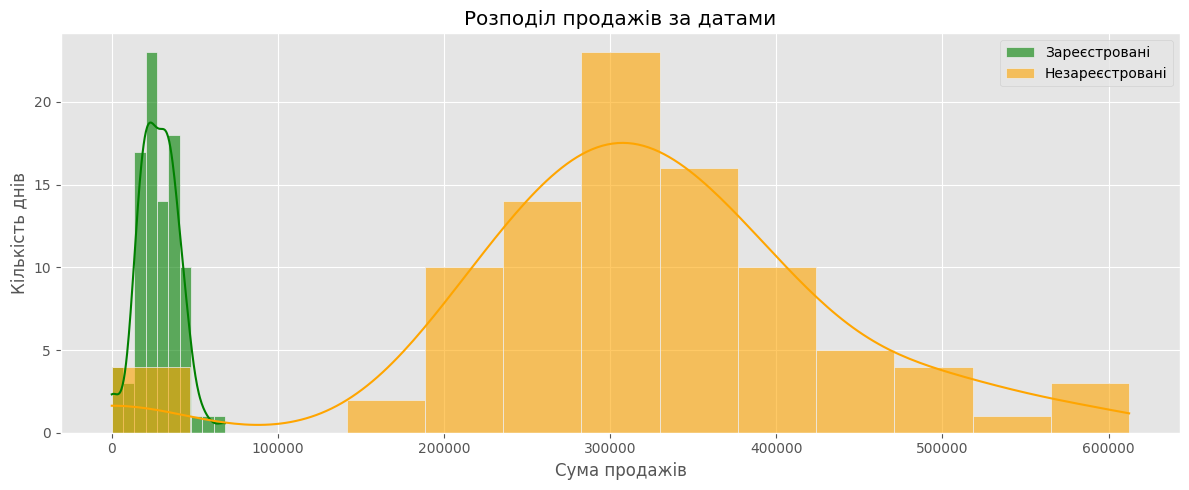

In [ ]:
# Зареєстровані / незареєстровані
registered = df[df['account_id'].notna()]
guest = df[df['account_id'].isna()]


# Сумарні продажі за кожну дату
registered_daily = registered.groupby('date')['price'].sum()
guest_daily = guest.groupby('date')['price'].sum()

# Об'єднуємо в одну таблицю
sales_comparison = pd.DataFrame({
    'registered': registered_daily,
    'guest': guest_daily
}).fillna(0)

# Візуалізація розподілів

plt.figure(figsize=(12, 5))
sns.histplot(sales_comparison['registered'], label='Зареєстровані', color='green', kde=True, alpha=0.6)
sns.histplot(sales_comparison['guest'], label='Незареєстровані', color='orange', kde=True, alpha=0.6)
plt.title('Розподіл продажів за датами')
plt.xlabel('Сума продажів')
plt.ylabel('Кількість днів')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
shapiro_registered = shapiro(sales_comparison['registered'])
shapiro_guest = shapiro(sales_comparison['guest'])

print("Shapiro Registered:", shapiro_registered)
print("Shapiro Guest:", shapiro_guest) # Статистичний тест, перевіримо нормальність розподілу

Shapiro Registered: ShapiroResult(statistic=np.float64(0.9791680485530986), pvalue=np.float64(0.14816728286235686))
Shapiro Guest: ShapiroResult(statistic=np.float64(0.9487769113384333), pvalue=np.float64(0.0012184604855253293))


In [ ]:
stat, p = mannwhitneyu(
    sales_comparison['registered'],
    sales_comparison['guest'],
    alternative='two-sided'
)

print(f"U-статистика = {stat:.2f}, p-value = {p:.4f}") # Тест для порівняння вибірок

U-статистика = 360.00, p-value = 0.0000


Попередній аналіз показав, що розподіл у групи гостей відхиляється від нормального (Shapiro-Wilk p = 0.0012), тому для оцінки різниці між вибірками було використано непараметричний тест Манна-Вітні.
За результатами тесту, різниця між медіанними обсягами продажів є статистично значущою (U = 360.0, p < 0.001).
Отже, зареєстровані та незареєстровані користувачі демонструють значно різну поведінку у контексті загальних сум покупок.





### **Проаналізуємо кількість сесій за різними каналами трафіку. Підберемо відповідний тест та дамо відповідь на питання: чи є статистично значущі відмінності між групами**

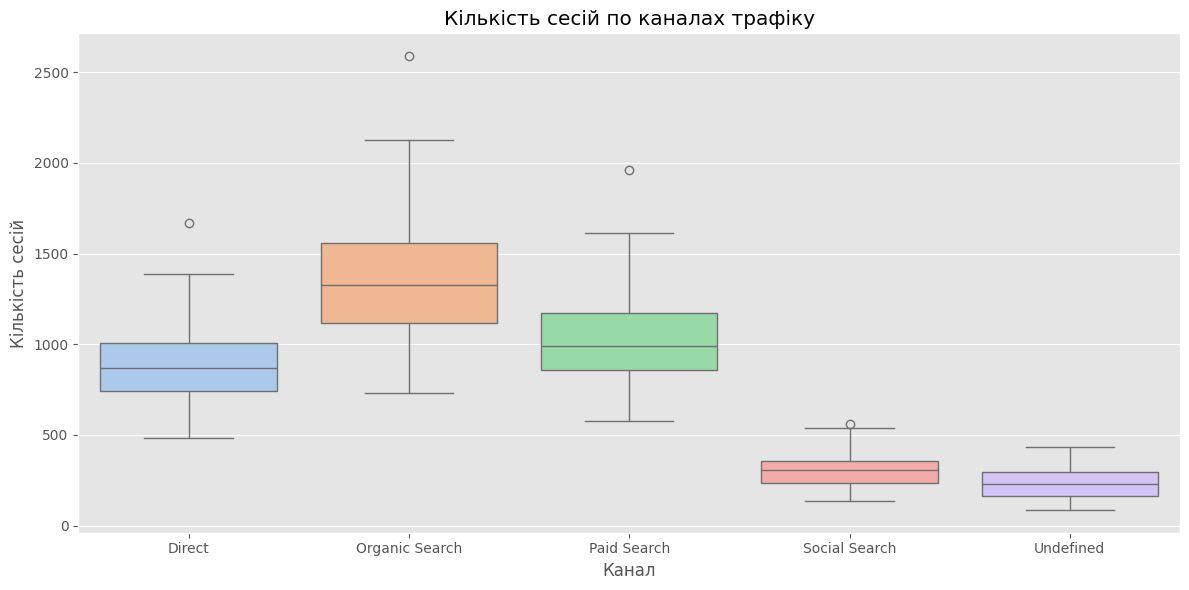

Kruskal-Wallis H-статистика: 368.98
p-value: 0.0000
✅ Є статистично значущі відмінності між каналами трафіку.


In [ ]:
# Видаляємо null
df_filtered = df[['channel', 'ga_session_id', 'date']].dropna(subset=['channel', 'ga_session_id', 'date'])

# Кількість сесій по кожній даті й каналу
sessions_by_day = df_filtered.groupby(['channel', 'date'])['ga_session_id'].nunique().reset_index()
sessions_by_day.columns = ['channel', 'date', 'n_sessions']

# Візуалізація
plt.figure(figsize=(12, 6))
sns.boxplot(data=sessions_by_day, x='channel', y='n_sessions', hue='channel', palette='pastel', legend=False)
plt.title("Кількість сесій по каналах трафіку")
plt.ylabel("Кількість сесій")
plt.xlabel("Канал")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Підготовка до тесту: групи
groups = [group['n_sessions'].values for name, group in sessions_by_day.groupby('channel')]

# Статистичний тест Крускала-Волліса
stat, p = kruskal(*groups)

# Вивід
print(f"Kruskal-Wallis H-статистика: {stat:.2f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("✅ Є статистично значущі відмінності між каналами трафіку.")
else:
    print("❌ Немає статистично значущих відмінностей між каналами.")

Візуалізація розподілів показала відчутні відмінності між каналами за рівнем медіани, розкидом і наявністю викидів.
Застосований непараметричний тест Крускала–Волліса підтвердив, що між щонайменше двома каналами є статистично значущі відмінності у кількості сесій (H = 368.98, p < 0.001).
Це свідчить про те, що користувачі поводяться по-різному залежно від джерела трафіку.


### **Дослідимо чи відрізняється статистично доля сесій з органічним трафіком у Європі та Америці. Підберемо відповідний тест та проведемо потрібні обчислення для створення вхідних даних до тесту**


In [ ]:
# Відфільтруємо тільки потрібні континенти
df_filtered = df[df['continent'].isin(['Europe', 'Americas'])]

# Кількість сесій з Organic Search у кожному регіоні
organic_counts = (
    df_filtered[df_filtered['channel'] == 'Organic Search']
    .groupby('continent')['ga_session_id']
    .nunique()
)

# Загальна кількість сесій у кожному регіоні
total_counts = (
    df_filtered
    .groupby('continent')['ga_session_id']
    .nunique()
)

# Побудова масивів для тесту
successes = [organic_counts.get('Europe', 0), organic_counts.get('Americas', 0)]
totals = [total_counts.get('Europe', 1), total_counts.get('Americas', 1)]  # уникаємо ділення на 0

# Z-тест для пропорцій
z_stat, p_value = proportions_ztest(successes, totals)

# Вивід результатів
print(f"Доля Organic в Європі: {successes[0]}/{totals[0]} = {successes[0]/totals[0]:.2%}")
print(f"Доля Organic в Америці: {successes[1]}/{totals[1]} = {successes[1]/totals[1]:.2%}")
print(f"Z-статистика: {z_stat:.2f}")
print(f"p-value: {p_value:.4f}")

Доля Organic в Європі: 23195/65135 = 35.61%
Доля Organic в Америці: 68671/193179 = 35.55%
Z-статистика: 0.29
p-value: 0.7722


Було проведено порівняння частки сесій з органічного пошуку між Європою та Америкою.
У Європі частка склала 35.61%, а в Америці — 35.55%.
Для перевірки статистичної значущості різниці застосовано z-тест для двох пропорцій, який показав:
z = 0.29, p = 0.7722.

Оскільки p > 0.05, ми не відкидаємо нульову гіпотезу. Це означає, що немає статистично значущої різниці між частками органічного трафіку в Європі та Америці.

Споживачі з обох регіонів однаково активно взаємодіють з органічними джерелами.

Можна не розділяти органічні кампанії по регіонах — реакція схожа.

Якщо потрібна оптимізація, слід шукати відмінності в інших джерелах трафіку або в поведінці після кліку (конверсії, середній чек тощо).


**ПОСИЛАННЯ НА ДАШБОРД У TABLEAU PUBLIC:** https://public.tableau.com/app/profile/daryna.sherenhova8856/viz/Salesanalysis_17484619552220/SalesAnalysis
